In [1]:
#importações;
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import differential_evolution, minimize
import statistics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Transformando os dados em %

In [2]:
# População total de cada região
populacao_total = {
    'NORTE': 14779178,
    'NORDESTE': 54428540,
    'SUDESTE': 83955553,
    'SUL': 28954866,
    'CENTROOESTE': 15326392
}

# Média de casos mensais por região
media_casos_mensais = {
    'NORTE': [867.6363636, 801.3636364, 932.2727273, 907.8181818, 929.4545455, 911.6363636, 904.9090909, 929.9090909, 888, 863.3636364, 842.2727273, 679.3636364],
    'NORDESTE': [2035.454545, 1858.363636, 2095.363636, 1959.181818, 2026.090909, 1872.090909, 2031.909091, 2106.181818, 1947.636364, 1974.727273, 1811.818182, 1449.181818],
    'SUDESTE': [3521.090909, 3183.181818, 3746.818182, 3284.636364, 3341.545455, 3275.181818, 3443.090909, 3615.636364, 3461.090909, 3489.272727, 3207.090909, 2673],
    'SUL': [950.4545455, 842.2727273, 948.3636364, 907, 903.7272727, 878.1818182, 938.2727273, 1013, 944.2727273, 977.4545455, 887.0909091, 739.1818182],
    'CENTROOESTE': [367.3636364, 342.8181818, 417.4545455, 369.1818182, 374.2727273, 359.0909091, 368.1818182, 384.8181818, 366.5454545, 366.5454545, 332.7272727, 265.1818182]
}

# Convertendo a média de casos mensais em porcentagem da população total de cada região
media_casos_percentual = {regiao: [casos / populacao_total[regiao] * 100 for casos in medias]
                          for regiao, medias in media_casos_mensais.items()}

# Criando um DataFrame para visualizar os resultados
df_percentual = pd.DataFrame(media_casos_percentual, index=[f'Mês {i+1}' for i in range(12)])

df_percentual

,NORTE,NORDESTE,SUDESTE,SUL,CENTROOESTE
Mês 1,0.005871,0.003740,0.004194,0.003283,0.002397
Mês 2,0.005422,0.003414,0.003792,0.002909,0.002237
Mês 3,0.006308,0.003850,0.004463,0.003275,0.002724
Mês 4,0.006143,0.003600,0.003912,0.003132,0.002409
Mês 5,0.006289,0.003722,0.003980,0.003121,0.002442
Mês 6,0.006168,0.003440,0.003901,0.003033,0.002343
Mês 7,0.006123,0.003733,0.004101,0.003240,0.002402
Mês 8,0.006292,0.003870,0.004307,0.003499,0.002511
Mês 9,0.006008,0.003578,0.004123,0.003261,0.002392
Mês 10,0.005842,0.003628,0.004156,0.003376,0.002392


# ESSE CÓDIGO, COSTUMA DEMORAR PARA RODAR, SE TIVER UM HPC, RODE NO HPC!
# Função para calcular as derivadas do modelo SIR
def SIR_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta):
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I
    return dS_dt, dI_dt, dR_dt

# Função para remover outliers usando o método do Z-score
def remove_outliers(data, threshold=1.5):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = [(x - mean) / std_dev for x in data]
    return [x for x, z in zip(data, z_scores) if abs(z) < threshold]

# Função para simular o modelo SIR com método de Euler
def euler_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max, dt)
    S_results, I_results, R_results = [S0], [I0], [R0]

    for t in times[1:]:
        dS, dI, dR = SIR_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta)
        S += dS * dt
        I += dI * dt
        R += dR * dt
        
        # Normalização para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total
        
        S_results.append(S)
        I_results.append(I)
        R_results.append(R)
    
    return times, S_results, I_results, R_results

# Função para simular o modelo SIR com método de Runge-Kutta de 4ª Ordem
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max, dt)
    S_results, I_results, R_results = [S0], [I0], [R0]

    for t in times[1:]:
        dS1, dI1, dR1 = SIR_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta)
        dS2, dI2, dR2 = SIR_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta)
        dS3, dI3, dR3 = SIR_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta)
        dS4, dI4, dR4 = SIR_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6

        # Normalização para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)
    
    return times, S_results, I_results, R_results

# Função de simulação do modelo SIR para infectados usando RK4
def simulate_sir_rk4(beta_f, S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta):
    _, _, I_rk4, _ = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta)
    return I_rk4

# Função de erro para minimizar usando RK4 (média quadrática)
def erro(beta_f, S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta, dias_medicao, dados_observados):
    I_rk4 = simulate_sir_rk4(beta_f, S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta)
    I_medicao = [I_rk4[int(dia / dt)] for dia in dias_medicao]
    erro_total = np.mean((np.array(I_medicao) - np.array(dados_observados)) ** 2)
    return erro_total

# Ajustar limites para otimização e definir parâmetros iniciais
bounds = [(0, 1)]  # Apenas beta
max_iter_de = 100  # Aumentar o número de iterações para Differential Evolution

# Definindo os valores iniciais de S, I e R para cada região
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Definindo os valores de gamma para cada região
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.006,
    'CENTROOESTE': 0.0067
}

# Definindo os valores de mu_i para cada região
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Dados de casos observados para cada região
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dicionários para armazenar dados sem outliers por região
dados_observados_sem_outliers_regioes = {}
dias_medicao_sem_outliers_regioes = {}

# Otimizar o parâmetro beta para cada região após remover outliers
parametros_otimizados_hibridos = {}
for regiao, valores in valores_iniciais.items():
    S0, I0, R0 = valores['S0'], valores['I0'], valores['R0']
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    dados_observados = media_casos_percentual[regiao]

    # Remover outliers dos dados observados usando Z-score
    dados_observados_sem_outliers = remove_outliers(dados_observados)
    
    # Armazenar dados sem outliers para a região
    dados_observados_sem_outliers_regioes[regiao] = dados_observados_sem_outliers
    
    # Ajustar dias de medição correspondentes aos dados observados sem outliers
    dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]
    dias_medicao_sem_outliers = [dias_medicao[i] for i in range(len(dados_observados)) if dados_observados[i] in dados_observados_sem_outliers]
    
    # Armazenar dias sem outliers para a região
    dias_medicao_sem_outliers_regioes[regiao] = dias_medicao_sem_outliers
    
    # Otimização com Differential Evolution
    resultado_de = differential_evolution(erro, bounds, args=(S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta, dias_medicao_sem_outliers, dados_observados_sem_outliers), maxiter=max_iter_de)
    
    # Refinar com L-BFGS-B
    resultado_lbfgsb = minimize(erro, resultado_de.x, args=(S0, I0, R0, t_max, dt, gamma_f, mu_s, mu_i, eta, dias_medicao_sem_outliers, dados_observados_sem_outliers), 
                                bounds=bounds, method='L-BFGS-B')
    
    # Salvando o parâmetro otimizado
    parametros_otimizados_hibridos[regiao] = resultado_lbfgsb.x[0]

    # Imprimir o parâmetro otimizado para cada região
    print(f"Parâmetro otimizado para a região {regiao} (sem outliers): Beta = {resultado_lbfgsb.x[0]:.4f}")

# Gerar gráficos das curvas de infectados com o parâmetro otimizado usando RK4
for regiao, valores in valores_iniciais.items():
    # Valores iniciais para a região
    S0, I0, R0 = valores['S0'], valores['I0'], valores['R0']
    beta_f = parametros_otimizados_hibridos[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    
    # Recuperar dados sem outliers para a região
    dados_observados_sem_outliers = dados_observados_sem_outliers_regioes[regiao]
    dias_medicao_sem_outliers = dias_medicao_sem_outliers_regioes[regiao]
    
    # Executar o modelo SIR com o parâmetro otimizado usando RK4
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta)
    
    # Plotar o resultado
    plt.figure(figsize=(12, 8))
    plt.plot(times_rk4, I_rk4, label=f'RK4 - Infectados ({regiao})', color='blue')
    plt.scatter(dias_medicao_sem_outliers, dados_observados_sem_outliers, color='black', label=f'Dados Observados ({regiao}) (Sem Outliers)', zorder=5)
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual de Infectados')
    plt.title(f'Curva de Infectados com Parâmetro Otimizado - {regiao} (Sem Outliers)')
    plt.legend()
    plt.show()

'''
Os valores encontrados devem ser;
Parâmetro otimizado para a região NORTE (sem outliers): Beta = 0.0107
Parâmetro otimizado para a região NORDESTE (sem outliers): Beta = 0.0099
Parâmetro otimizado para a região SUDESTE (sem outliers): Beta = 0.0098
Parâmetro otimizado para a região SUL (sem outliers): Beta = 0.0097
Parâmetro otimizado para a região CENTROOESTE (sem outliers): Beta = 0.0098
'''

# Agora que sabemos um beta base para cada região considerando um crescimento populacional estavel, vamos fazer algumas alterações

- Vamos adicionar os dados de nascimento e morte de cada região;
- Vamos alterar o beta para os novos dados adicionados ao modelo; e
- Vamos implementar o modelo SIRS.

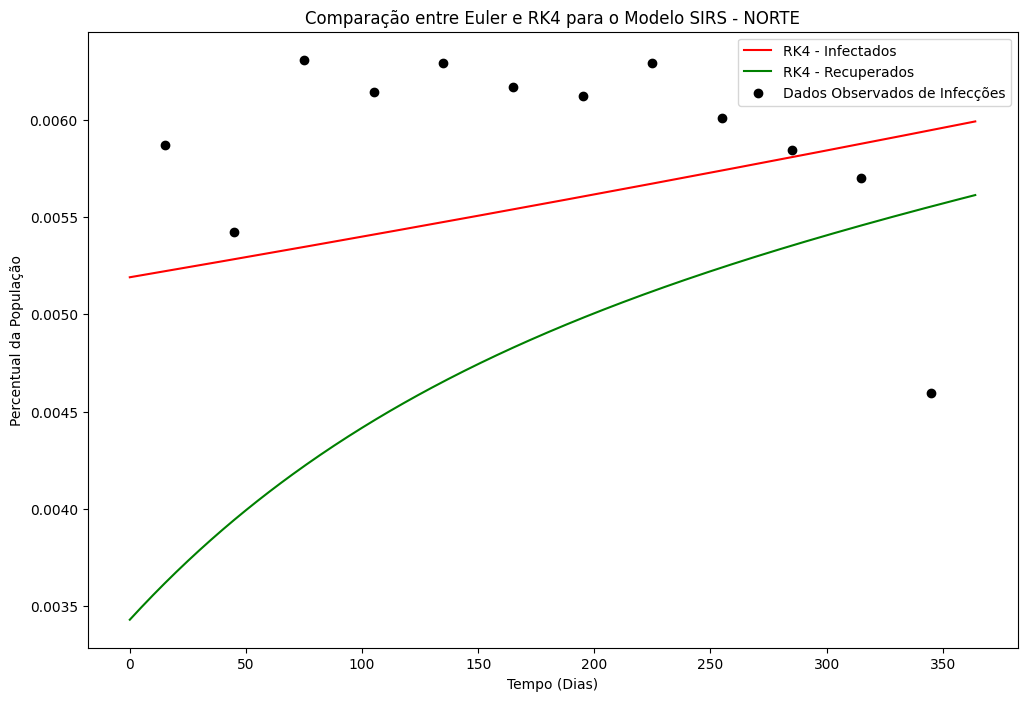

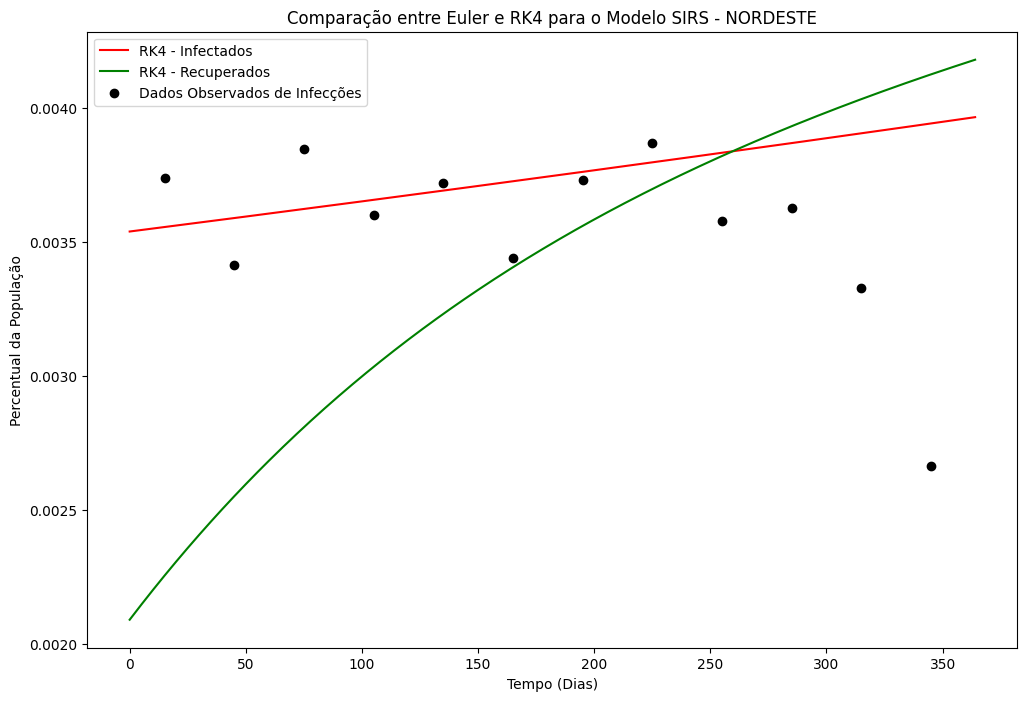

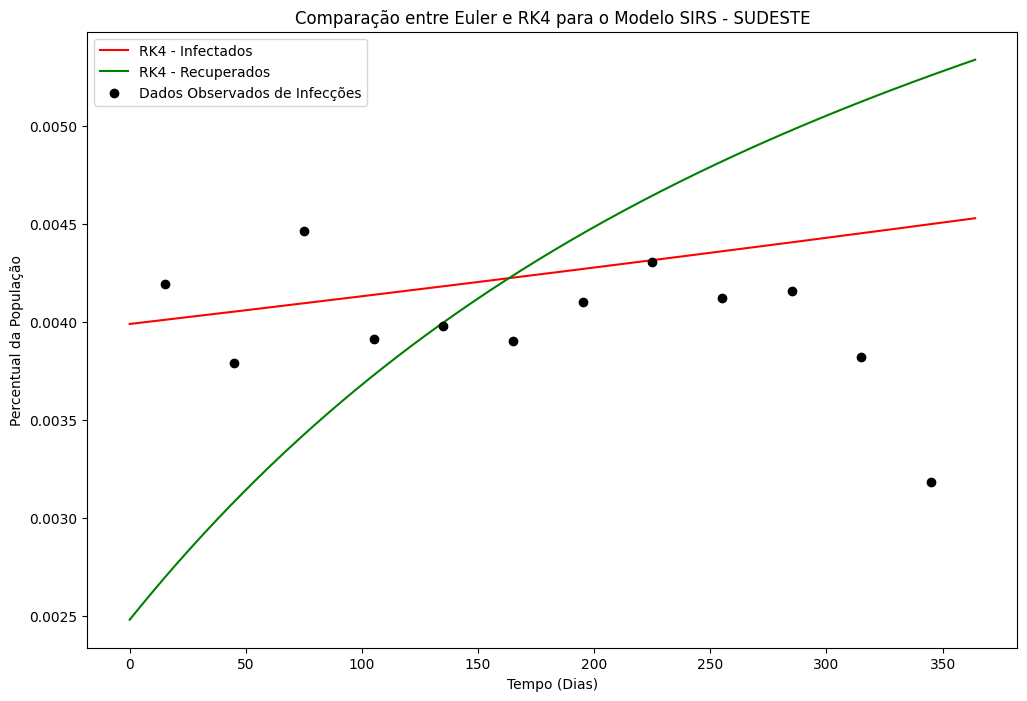

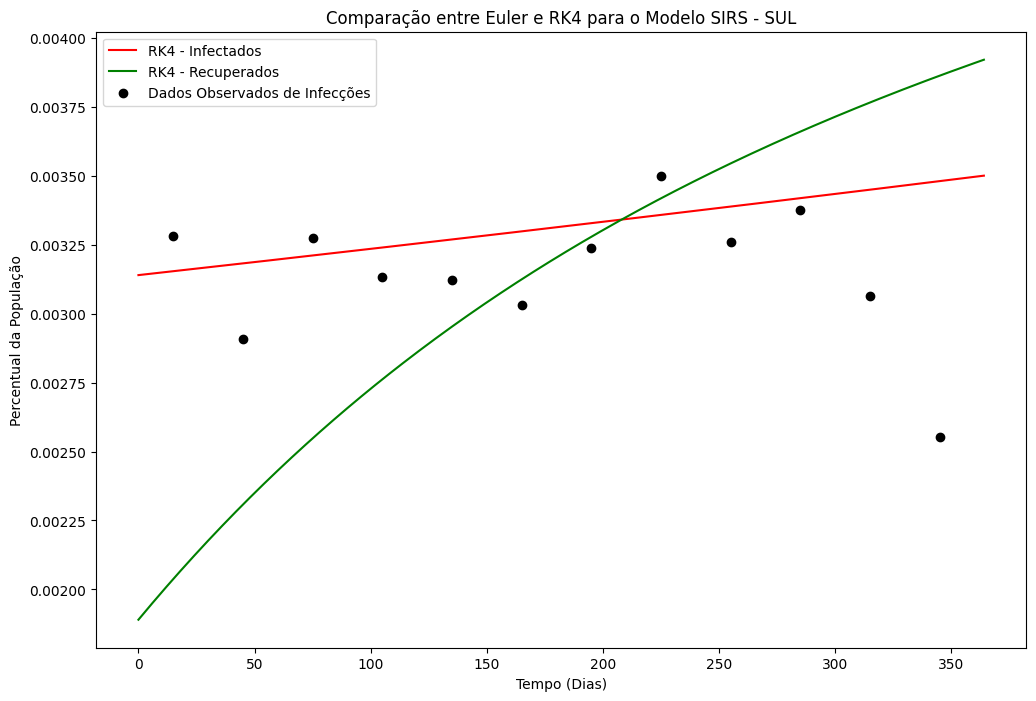

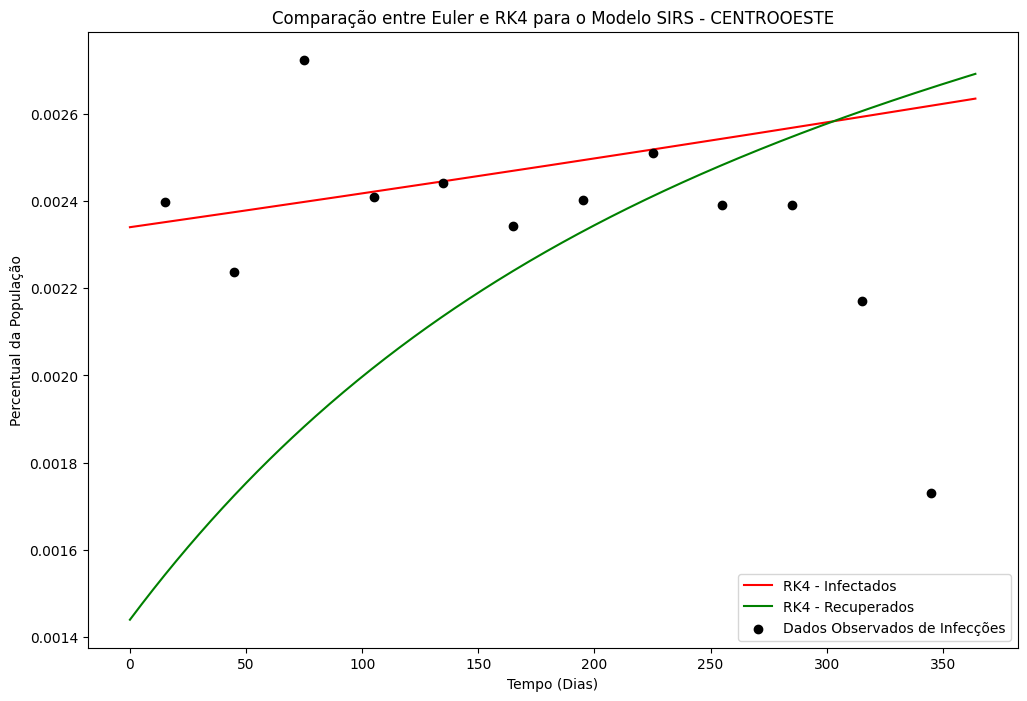

In [3]:
# Função para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equações SIRS.
    
    Parâmetros:
    - S: População suscetível (%)
    - I: População infectada (%)
    - R: População recuperada (%)
    - beta_f: Taxa de transmissão
    - gamma_f: Taxa de recuperação
    - mu_s: Taxa de mortalidade natural (suscetíveis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na população
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscetíveis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# Método de Euler para SIRS
def euler_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max, dt)
    S_results, I_results, R_results = [S0], [I0], [R0]

    for t in times[1:]:
        dS, dI, dR = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        S += dS * dt
        I += dI * dt
        R += dR * dt
        
        # Normalização para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total
        
        S_results.append(S)
        I_results.append(I)
        R_results.append(R)
    
    return times, S_results, I_results, R_results

# Método de Runge-Kutta de 4ª Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max, dt)
    S_results, I_results, R_results = [S0], [I0], [R0]

    for t in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6

        # Normalização para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)
    
    return times, S_results, I_results, R_results

# Parâmetros de simulação
t_max = 365  # Tempo máximo de simulação
dt = 1  # Tamanho do passo de tempo

# Definindo os valores de beta para cada região
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

# Definindo os valores de gamma para cada região
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.006,
    'CENTROOESTE': 0.0067
}

# Definindo os valores de mu_i para cada região
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada região
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada região
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada região
xi_valores = {
    'NORTE': 0.0073/2,
    'NORDESTE': 0.0064/2,
    'SUDESTE': 0.0068/2,
    'SUL': 0.006/2,
    'CENTROOESTE': 0.0067/2
}

# Definindo os valores iniciais de S, I e R para cada região
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de média de casos em percentual para cada região
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Criando gráficos para cada região
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medição
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Criando gráficos para cada região com os pontos de dados observados nos dias de medição
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a região atual
    
    # Executando os métodos
    times_euler, S_euler, I_euler, R_euler = euler_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    #plt.plot(times_euler, S_euler, label='Euler - Suscetíveis', linestyle='--', color='blue')
    #plt.plot(times_rk4, S_rk4, label='RK4 - Suscetíveis', color='blue')
    #plt.plot(times_euler, I_euler, label='Euler - Infectados', linestyle='--', color='red')
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados', color='red')
    #plt.plot(times_euler, R_euler, label='Euler - Recuperados', linestyle='--', color='green')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Adicionando dados observados como pontos nos dias de medição
    plt.scatter(dias_medicao, media_casos_percentual[regiao], color='black', label='Dados Observados de Infecções', zorder=5)

    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da População')
    plt.title(f'Comparação entre Euler e RK4 para o Modelo SIRS - {regiao}')
    plt.legend()
    plt.show()

# Vamos aprimorar esses gráficos;
- Vamos adicionar o desvio padrão aos dados mensais de infecção;
- Vamos adicionar uma faixa de infecção a partir dos valores de desvio padrão dos infectados; e
- Vamos colocar todos os gráficos na mesma escala.

Gráfico salvo em: NORTE_SIRS_plot.png


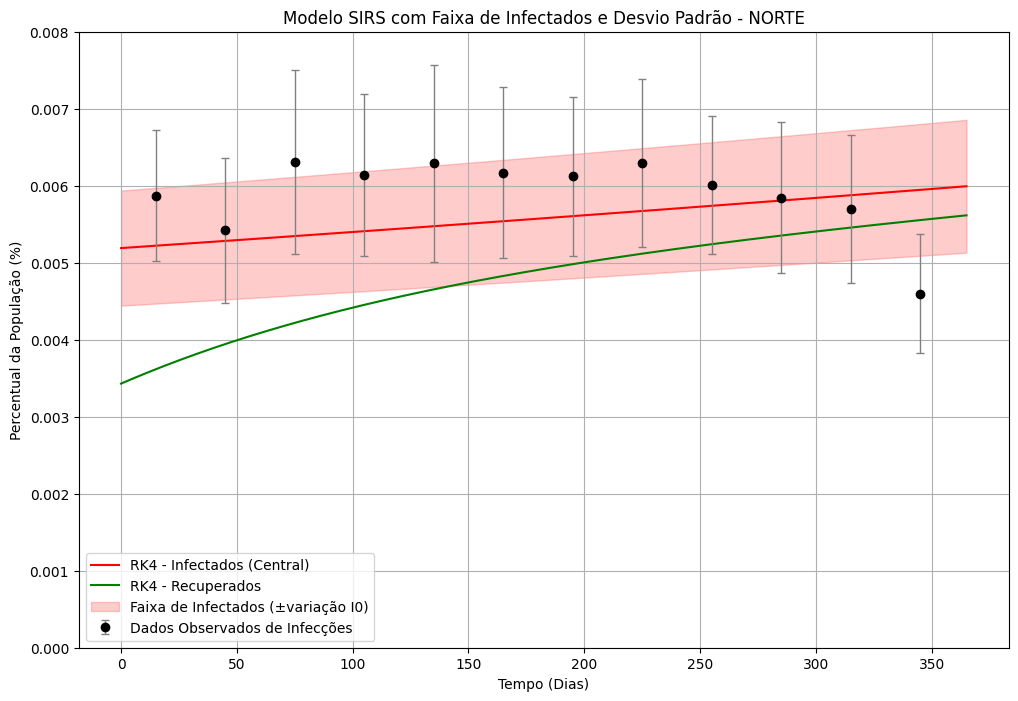

Gráfico salvo em: NORDESTE_SIRS_plot.png


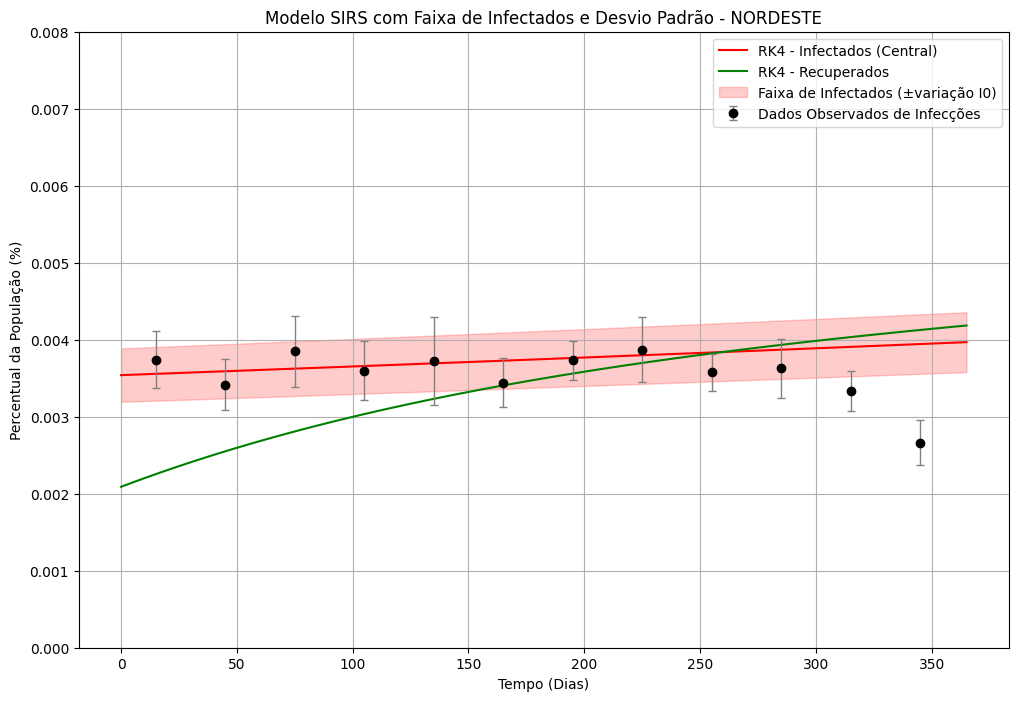

Gráfico salvo em: SUDESTE_SIRS_plot.png


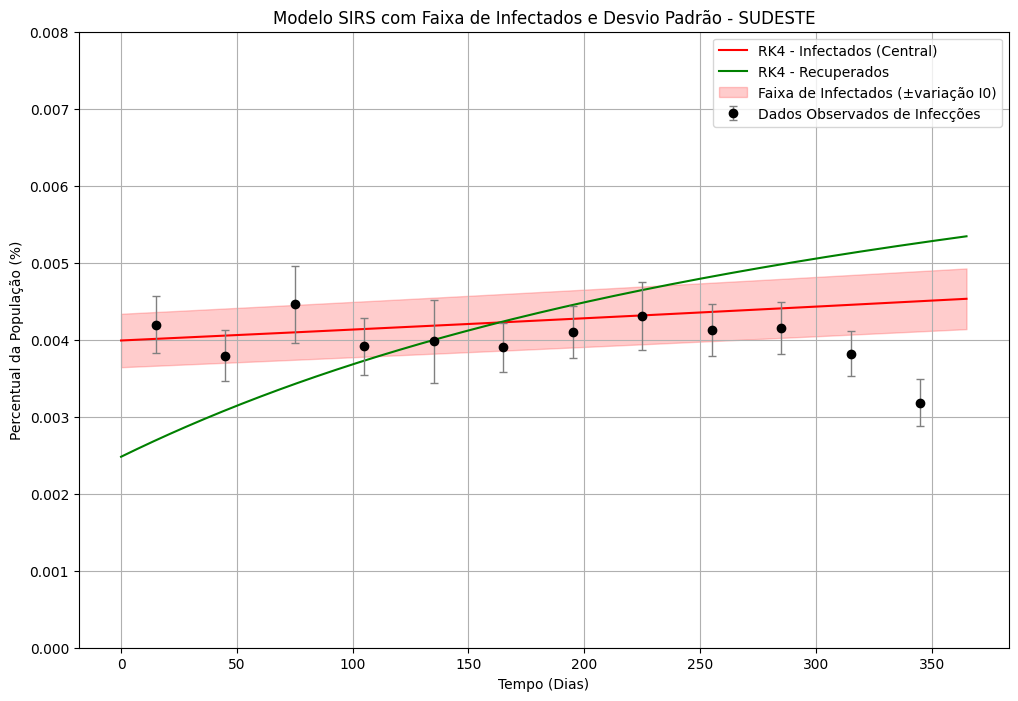

Gráfico salvo em: SUL_SIRS_plot.png


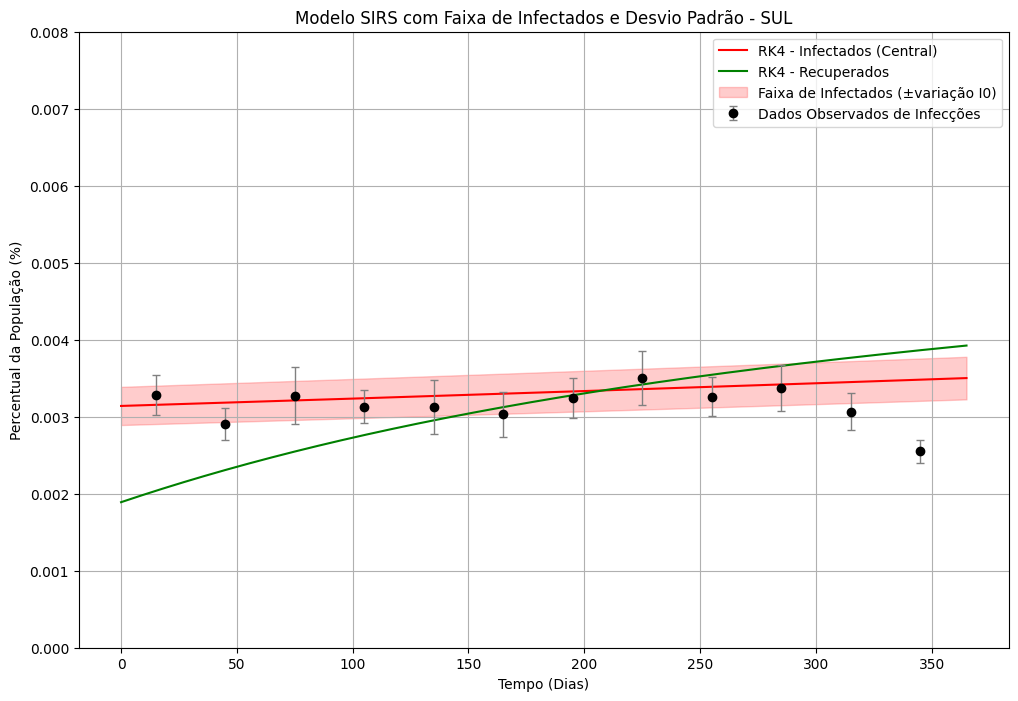

Gráfico salvo em: CENTROOESTE_SIRS_plot.png


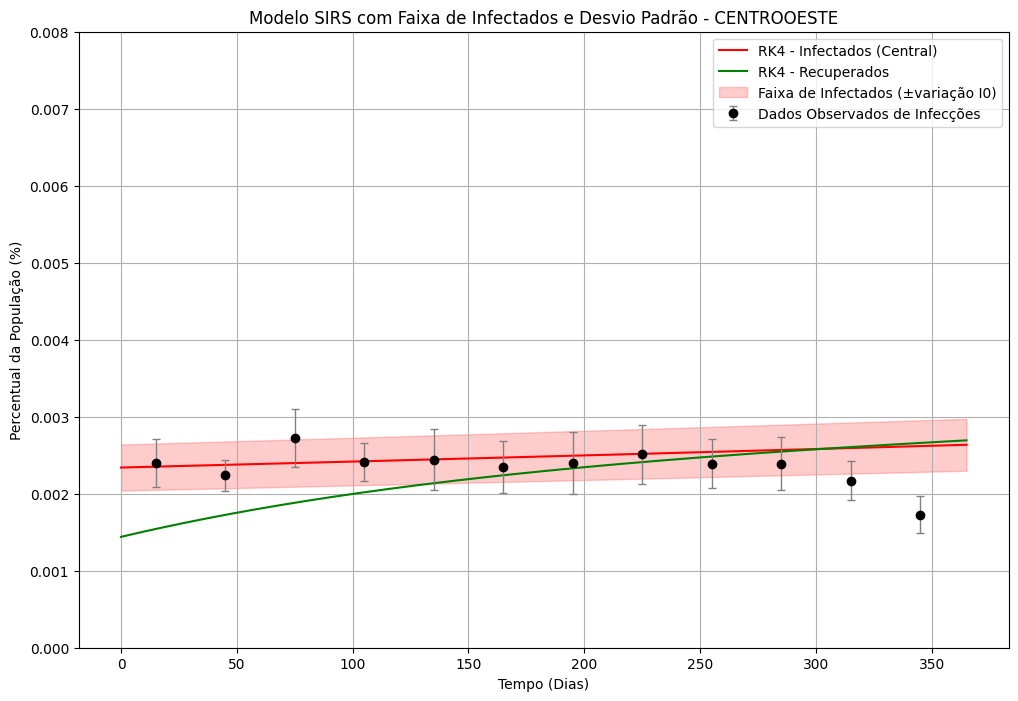

In [4]:
# Função para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equações SIRS.
    
    Parâmetros:
    - S: População suscetível (%)
    - I: População infectada (%)
    - R: População recuperada (%)
    - beta_f: Taxa de transmissão
    - gamma_f: Taxa de recuperação
    - mu_s: Taxa de mortalidade natural (suscetíveis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na população
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscetíveis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# Método de Runge-Kutta de 4ª Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max + dt, dt)  # Inclui t_max
    S_results, I_results, R_results = [S0], [I0], [R0]

    for _ in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6  # Correção aqui

        # Normalização para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)

    return times, S_results, I_results, R_results

# Parâmetros de simulação
t_max = 365  # Tempo máximo de simulação (dias)
dt = 1       # Tamanho do passo de tempo (dias)

# Definindo os valores de beta para cada região
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

# Definindo os valores de gamma para cada região
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.006,
    'CENTROOESTE': 0.0067
}

# Definindo os valores de mu_i para cada região
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada região
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada região
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada região
xi_valores = {
    'NORTE': 0.0073 / 2,
    'NORDESTE': 0.0064 / 2,
    'SUDESTE': 0.0068 / 2,
    'SUL': 0.006 / 2,
    'CENTROOESTE': 0.0067 / 2
}

# Definindo os valores iniciais de S, I e R para cada região
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de média de casos em percentual para cada região
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dados de desvio padrão de casos em percentual para cada região
desvio_padrao_casos_percentual = {
    'NORTE': [0.00085, 0.00094, 0.00119, 0.00105, 0.00128, 0.00111, 0.00103, 0.00109, 0.0009, 0.00098, 0.00096, 0.00077],
    'NORDESTE': [0.00037, 0.00033, 0.00046, 0.00038, 0.00057, 0.00032, 0.00025, 0.00042, 0.00024, 0.00038, 0.00026, 0.00029],
    'SUDESTE': [0.00037, 0.00033, 0.0005, 0.00037, 0.00054, 0.00032, 0.00034, 0.00044, 0.00034, 0.00034, 0.00029, 0.00031],
    'SUL': [0.00026, 0.00021, 0.00037, 0.00022, 0.00035, 0.00029, 0.00026, 0.00035, 0.00025, 0.0003, 0.00024, 0.00015],
    'CENTROOESTE': [0.00031, 0.0002, 0.00038, 0.00025, 0.0004, 0.00034, 0.0004, 0.00038, 0.00032, 0.00035, 0.00025, 0.00024]
}

# Definindo a variação de I0 para cada região (porcentagem decimal, ex: 0.144 para 14.4%)
variacao_I0_valores = {
    'NORTE': 0.144,
    'NORDESTE': 0.098,
    'SUDESTE': 0.087,
    'SUL': 0.079,
    'CENTROOESTE': 0.128
}

# Criando gráficos para cada região
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medição
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Definindo limites do eixo Y
y_min = 0
y_max = 0.008  # 1%

# Criando gráficos para cada região com os pontos de dados observados nos dias de medição
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a região atual
    variacao_I0 = variacao_I0_valores[regiao]  # Variação de I0 para a região atual

    # Definindo dois valores de I0 para criar a faixa (±variação_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o método RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o método RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o método RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    
    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high, color='red', alpha=0.2, label='Faixa de Infectados (±variação I0)')
    
    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao, 
        media_casos_percentual[regiao], 
        yerr=desvio_padrao_casos_percentual[regiao], 
        fmt='o', 
        color='black', 
        ecolor='gray', 
        elinewidth=1, 
        capsize=3, 
        label='Dados Observados de Infecções',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)
    
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da População (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padrão - {regiao}')
    plt.legend()
    plt.grid(True)
    # Salvar o gráfico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gráfico salvo em: {filename}')
    
    # Exibir o gráfico
    plt.show()

# Calculando o valor de 'R0'(número básico de reprodução) de cada região

In [5]:
# Definindo a função para calcular R₀
def calcular_R0(beta_f, gamma_f, mu_i):
    return beta_f / (gamma_f + mu_i)

# Listando as regiões
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']

# Parâmetros de beta, gamma, mu_i e mu_s para cada região (já definidos no seu código)
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.0060,
    'CENTROOESTE': 0.0067
}

mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.0030,
    'SUL': 0.0037,
    'CENTROOESTE': 0.0030
}

# Calculando e exibindo o R₀ para cada região
for regiao in regioes:
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    
    R0 = calcular_R0(beta_f, gamma_f, mu_i)
    print(f"R₀ da região {regiao}: {R0:.4f}")

R₀ da região NORTE: 1.3970
R₀ da região NORDESTE: 1.2551
R₀ da região SUDESTE: 1.1980
R₀ da região SUL: 1.1948
R₀ da região CENTROOESTE: 1.3000


### Interpretação dos Resultados:

R₀ > 1: Indica que a doença tende a se espalhar na região.

R₀ = 1: A doença se mantém estável na população.

R₀ < 1: A doença tende a diminuir e eventualmente desaparecer.

# Pontos de equilíbrio triviais e não-triviais

Os pontos de equilíbrio triviais são as situações onde a variação de cada compartimento é 0, logo, não há infectados nem recuperados, e a quantidade de suscetíveis se mantém igual à população total.

Como esta não é a situação real, encontramos também os pontos de equilíbrio não-triviais, os quais dependem das taxas intrínsecas da doença

In [6]:
# Função para calcular R0
def calcular_R0(beta_f, gamma_f, mu_i, mu_s):
    return beta_f / (gamma_f + mu_i)

# Encontrando pontos de equilíbrio
def ponto_equilibrio(beta_f, gamma_f, mu_s, mu_i, eta, xi):
    # Ponto de equilíbrio trivial
    S_eq_trivial, I_eq_trivial, R_eq_trivial = 1, 0, 0
    
    # Pontos de equilíbrio não triviais
    R0 = calcular_R0(beta_f, gamma_f, mu_i, mu_s)
    
    # Equilíbrio para S
    S_eq = 1 / R0
    # Equilíbrio para I
    I_eq = mu_i * (R0 - 1) / beta_f
    # Equilíbrio para R
    R_eq = 1 - S_eq - I_eq  # Total deve ser 1 (população normalizada)
    
    # Normalização para garantir proporção correta da população (S_eq + I_eq + R_eq = 1)
    total = S_eq + I_eq + R_eq
    S_eq /= total
    I_eq /= total       
    R_eq /= total
    
    return (S_eq_trivial, I_eq_trivial, R_eq_trivial), (S_eq, I_eq, R_eq)

# Calculando pontos de equilíbrio para cada região
for regiao in regioes:
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]
    
    trivial, n_trivial = ponto_equilibrio(beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    print(f"Ponto de equilíbrio trivial da região {regiao}: S = {trivial[0]:.4f}, I = {trivial[1]:.4f}, R = {trivial[2]:.4f}")
    print(f"Ponto de equilíbrio não-trivial da região {regiao}: S = {n_trivial[0]:.4f}, I = {n_trivial[1]:.4f}, R = {n_trivial[2]:.4f}")

Ponto de equilíbrio trivial da região NORTE: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equilíbrio não-trivial da região NORTE: S = 0.7158, I = 0.0767, R = 0.2075
Ponto de equilíbrio trivial da região NORDESTE: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equilíbrio não-trivial da região NORDESTE: S = 0.7967, I = 0.0705, R = 0.1327
Ponto de equilíbrio trivial da região SUDESTE: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equilíbrio não-trivial da região SUDESTE: S = 0.8348, I = 0.0506, R = 0.1147
Ponto de equilíbrio trivial da região SUL: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equilíbrio não-trivial da região SUL: S = 0.8369, I = 0.0622, R = 0.1009
Ponto de equilíbrio trivial da região CENTROOESTE: S = 1.0000, I = 0.0000, R = 0.0000
Ponto de equilíbrio não-trivial da região CENTROOESTE: S = 0.7692, I = 0.0714, R = 0.1594


# Analise de estabilidade

Na análise de estabilidade, foi tomada a Jacobiana dos compartimentos S,I,R, para que a partir dos autovalores, possa ser identificada a estabilidade (parte real negativa) ou instabilidade (parte real positiva) de cada região.

Se uma região se mostrar instável, isso mostra que, uma pequena variação no número de infectados pode indicar uma nova potencial epidemia naquela região, visto que os valores irão se afastar do ponto de estabilidade, o qual representa a situação de infectados e recuperados linear, característico da tuberculose.

Se uma região se mostrar estável, isso mostra que mesmo com variações no número de infectados, a chance de se ocorrer uma epidemia é baixa, visto que o sistema irá tender a se aproximar no ponto de estabilidade novamente.

In [7]:
# Função para calcular a Jacobiana no ponto de equilíbrio
def jacobiana(S_eq, I_eq, R_eq, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    # Derivadas parciais das equações do sistema SIRS
    J = np.array([
        [-(beta_f * I_eq) + (eta - mu_s), -(beta_f * S_eq), xi],
        [beta_f * I_eq, (beta_f * S_eq) - (gamma_f + mu_i), 0],
        [0, gamma_f, -xi]
    ])
    return J

# Função para verificar a estabilidade
def verificar_estabilidade(beta_f, gamma_f, mu_s, mu_i, eta, xi):
    # Calcula os pontos de equilíbrio
    trivial, n_trivial = ponto_equilibrio(beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Calcula a Jacobiana no ponto de equilíbrio não trivial
    S_eq, I_eq, R_eq = n_trivial
    J = jacobiana(S_eq, I_eq, R_eq, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Calcula os autovalores da matriz Jacobiana
    autovalores = np.linalg.eigvals(J)
    
    # Verifica se todos os autovalores têm parte real negativa (condição de estabilidade)
    if all(np.real(autoval) < 0 for autoval in autovalores):
        return "Estável", autovalores
    else:
        return "Instável", autovalores

# Testando a função para cada região
for regiao in regioes:
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]

    estabilidade, autovalores = verificar_estabilidade(beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    print(f"Região {regiao}: {estabilidade}")
    print(f"Autovalores: {autovalores}")

Região NORTE: Instável
Autovalores: [ 0.00062476+0.00201599j  0.00062476-0.00201599j -0.00237141+0.j        ]
Região NORDESTE: Instável
Autovalores: [ 9.05825249e-05+0.00214439j  9.05825249e-05-0.00214439j
 -2.04851199e-03+0.j        ]
Região SUDESTE: Instável
Autovalores: [ 1.88997902e-05+0.00157821j  1.88997902e-05-0.00157821j
 -2.43167713e-03+0.j        ]
Região SUL: Estável
Autovalores: [-7.49968954e-05+0.00201359j -7.49968954e-05-0.00201359j
 -1.97093404e-03+0.j        ]
Região CENTROOESTE: Instável
Autovalores: [ 0.00026052+0.00202443j  0.00026052-0.00202443j -0.00217104+0.j        ]


# Calculando o beta_intrinseco da TB

In [8]:
# Dados fornecidos
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

SEIDH_valores = {
    'NORTE': 0.71,
    'NORDESTE': 0.69,
    'SUDESTE': 0.78,
    'SUL': 0.79,
    'CENTROOESTE': 0.77
}

dp_valores = {
    'NORTE': 4.51,
    'NORDESTE': 35.21,
    'SUDESTE': 91.76,
    'SUL': 51.91,
    'CENTROOESTE': 10.14
}

# Função para normalizar DP usando DP_max
def normalizar_dp_dpmax(dp_dict):
    dp_max = max(dp_dict.values())
    f_dp = {}
    for regiao, dp in dp_dict.items():
        if dp_max != 0:
            f_dp[regiao] = dp / dp_max
        else:
            f_dp[regiao] = 0  # Evita divisão por zero
    return f_dp, dp_max

# Calcular f(DP) para cada região e obter DP_max
f_dp, dp_max = normalizar_dp_dpmax(dp_valores)

# Cálculo do beta intrínseco usando a fórmula ajustada
beta_intrinseco = {}

for regiao in beta_valores:
    beta = beta_valores[regiao]           # Beta observado
    SEIDH = SEIDH_valores[regiao]         # Índice de Desenvolvimento Humano
    DP = dp_valores[regiao]               # Densidade demográfica
    
    # Calcular f(DP) = DP / DP_max
    f_DP = f_dp[regiao]
    
    # Aplicar a fórmula ajustada
    beta_int = beta * (1 + f_DP) / (1 + SEIDH)
    
    beta_intrinseco[regiao] = beta_int

# Cálculo das diferenças entre beta_valores e beta_intrinseco
diferenca_betas = {}

for regiao in beta_valores:
    diferenca = beta_valores[regiao] - beta_intrinseco[regiao]
    diferenca_betas[regiao] = diferenca

# Exibindo os resultados
print("Resultados do cálculo do Beta Intrínseco e Diferenças:\n")
print(f"{'Região':<15}{'β_valores':<15}{'β_intrínseco':<20}{'Diferença':<15}")
print("-" * 65)
for regiao in beta_valores:
    print(f"{regiao:<15}{beta_valores[regiao]:<15.6f}{beta_intrinseco[regiao]:<20.6f}{diferenca_betas[regiao]:<15.6f}")

Resultados do cálculo do Beta Intrínseco e Diferenças:

Região         β_valores      β_intrínseco        Diferença      
-----------------------------------------------------------------
NORTE          0.013970       0.008571            0.005399       
NORDESTE       0.012300       0.010071            0.002229       
SUDESTE        0.011740       0.013191            -0.001451      
SUL            0.011590       0.010138            0.001452       
CENTROOESTE    0.012610       0.007912            0.004698       


## Observações:

NORTE:

DP Normalizado: 0.0492 (Baixa densidade demográfica)
SEIDH: 0.71 (Moderadamente alto)
β_intrínseco: 0.008571 (menor que β_valores)
Diferença: 0.005379
NORDESTE:

DP Normalizado: 0.3832 (Moderada densidade demográfica)
SEIDH: 0.69 (Moderadamente alto)
β_intrínseco: 0.010080 (menor que β_valores)
Diferença: 0.002220
SUDESTE:

DP Normalizado: 1.0 (Maior densidade demográfica)
SEIDH: 0.78 (Alto)
β_intrínseco: 0.013180 (maior que β_valores)
Diferença: -0.001440
SUL:

DP Normalizado: 0.5663 (Alta densidade demográfica)
SEIDH: 0.79 (Alto)
β_intrínseco: 0.010150 (menor que β_valores)
Diferença: 0.001450
CENTROOESTE:

DP Normalizado: 0.1105 (Moderadamente baixa densidade demográfica)
SEIDH: 0.77 (Alto)
β_intrínseco: 0.007900 (menor que β_valores)
Diferença: 0.004720

## Análise dos Resultados:
Consistência com a Lógica Epidemiológica:

Maior DP: Regiões com maior densidade demográfica (como SUDESTE) deveriam ter maior β_valores, o que ocorreu, exceto que SUDESTE apresentou β_valores ligeiramente menores que β_intrinseco devido ao alto SEIDH.
Maior SEIDH: Regiões com maior SEIDH (como SUDESTE e SUL) têm β_valores reduzido ou ligeiramente aumentado, dependendo da relação com DP.

Diferenças Mínimas:

A maioria das diferenças entre β_valores e β_intrínseco são pequenas (entre ~0.001 a ~0.005), mantendo-os na mesma ordem de magnitude, conforme esperado.

Exceção: SUDESTE

SUDESTE: Apesar de ter a maior densidade demográfica, seu alto SEIDH resulta em um β_valores ligeiramente menor que β_intrinseco. Isso pode ocorrer devido à relação proporcional na fórmula, onde (1 + f(DP)) aumenta β_valores, mas (1 + SEIDH) também aumenta, porém menos proporcionalmente. O que pode indicar que o fator do IDH está diminuindo o β_valores

In [9]:
dados = {
    "Região": ["NORTE", "NORDESTE", "SUDESTE", "SUL", "CENTROOESTE"],
    "β_valores": [0.013970, 0.012300, 0.011740, 0.011590, 0.012610],
    "β_intrínseco": [0.008571, 0.010071, 0.013191, 0.010138, 0.007912]
}

# Calcular a média e desvio padrão para β_valores
media_valores = np.mean(dados["β_valores"])
desvio_valores = np.std(dados["β_valores"], ddof=1)

# Calcular a média e desvio padrão para β_intrínseco
media_intrinseco = np.mean(dados["β_intrínseco"])
desvio_intrinseco = np.std(dados["β_intrínseco"], ddof=1)

# Exibir os resultados
print(f"Média de β_valores: {media_valores:.6f}")
print(f"Desvio padrão de β_valores: {desvio_valores:.6f}")
print(f"Média de β_intrínseco: {media_intrinseco:.6f}")
print(f"Desvio padrão de β_intrínseco: {desvio_intrinseco:.6f}")

Média de β_valores: 0.012442
Desvio padrão de β_valores: 0.000949
Média de β_intrínseco: 0.009977
Desvio padrão de β_intrínseco: 0.002037


# Código bonus: balanceando a influencia de DP e SEIDH no modelo

In [10]:
# Definição dos coeficientes a serem testados
alpha_values = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 1, 1, 1]  # Coeficientes para f(DP)
beta_coef_values = [0.1, 0.5, 1, 0.1, 0.5, 1, 0.1, 0.5, 1,]  # Coeficientes para SEIDH

# Dicionário para armazenar os resultados de cada combinação
resultados_teste = []

# Loop para cada combinação de alpha e beta_coef
for i in range(len(alpha_values)):
    alpha = alpha_values[i]
    beta_coef = beta_coef_values[i]
    
    # Cálculo do beta intrínseco ajustado
    beta_intrinseco_adjusted = {}
    for regiao in beta_valores:
        beta = beta_valores[regiao]           # Beta observado
        SEIDH = SEIDH_valores[regiao]         # Índice de Desenvolvimento Humano
        DP = dp_valores[regiao]               # Densidade demográfica
        
        # Calcular f(DP) = DP / DP_max
        f_DP = f_dp[regiao]
        
        # Aplicar a fórmula ajustada com coeficientes
        beta_int = beta * (1 + alpha * f_DP) / (1 + beta_coef * SEIDH)
        beta_intrinseco_adjusted[regiao] = beta_int

    # Cálculo das diferenças entre beta_valores e beta_intrinseco_adjusted
    diferenca_betas_adjusted = {}
    for regiao in beta_valores:
        diferenca = beta_valores[regiao] - beta_intrinseco_adjusted[regiao]
        diferenca_betas_adjusted[regiao] = diferenca
    
    # Armazenando o resultado da combinação atual
    resultados_teste.append({
        'alpha': alpha,
        'beta_coef': beta_coef,
        'beta_intrinseco_adjusted': beta_intrinseco_adjusted,
        'diferenca_betas_adjusted': diferenca_betas_adjusted
    })

# Exibindo os resultados de cada combinação
for resultado in resultados_teste:
    print(f"\nResultados para alpha = {resultado['alpha']} e beta_coef = {resultado['beta_coef']}:\n")
    print(f"{'Região':<15}{'β_valores':<15}{'β_intrínseco':<20}{'Diferença':<15}")
    print("-" * 65)
    for regiao in beta_valores:
        print(f"{regiao:<15}{beta_valores[regiao]:<15.6f}{resultado['beta_intrinseco_adjusted'][regiao]:<20.6f}{resultado['diferenca_betas_adjusted'][regiao]:<15.6f}")


Resultados para alpha = 0.1 e beta_coef = 0.1:

Região         β_valores      β_intrínseco        Diferença      
-----------------------------------------------------------------
NORTE          0.013970       0.013108            0.000862       
NORDESTE       0.012300       0.011948            0.000352       
SUDESTE        0.011740       0.011980            -0.000240      
SUL            0.011590       0.011349            0.000241       
CENTROOESTE    0.012610       0.011838            0.000772       

Resultados para alpha = 0.1 e beta_coef = 0.5:

Região         β_valores      β_intrínseco        Diferença      
-----------------------------------------------------------------
NORTE          0.013970       0.010361            0.003609       
NORDESTE       0.012300       0.009496            0.002804       
SUDESTE        0.011740       0.009291            0.002449       
SUL            0.011590       0.008778            0.002812       
CENTROOESTE    0.012610       0.009205      

## OBS:

α e 𝛽: Ajuste esses valores para calibrar a influência relativa de DP e SEIDH. 

Por exemplo, se desejar que DP tenha menos influência, defina 𝛼 < 1.
Caso contrario defina que 𝛽 < 1.

## Talvez o desvio padrão ajude a decidir os valores de alpha e beta nesse caso

# Calculando o Gamma_intrinseco da TB

In [11]:
# Dados fornecidos
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.0060,
    'CENTROOESTE': 0.0067
}

SASUS_valores = {
    'NORTE': 0.1775,
    'NORDESTE': 0.198,
    'SUDESTE': 0.20675,
    'SUL': 0.23175,
    'CENTROOESTE': 0.21775
}

# Função para calcular gamma_intrinseco
def calcular_gamma_intrinseco(gamma_valores, SASUS_valores):
    gamma_intrinseco = {}
    for regiao in gamma_valores:
        gamma = gamma_valores[regiao]
        SASUS = SASUS_valores[regiao]
        # Aplicar a fórmula: gamma_intrinseco = gamma_valores / (1 + SASUS)
        gamma_int = gamma / (1 + SASUS)
        gamma_intrinseco[regiao] = gamma_int
    return gamma_intrinseco

# Função para calcular a diferença entre gamma_valores e gamma_intrinseco
def calcular_diferenca_gamma(gamma_valores, gamma_intrinseco):
    diferenca = {}
    for regiao in gamma_valores:
        diferenca_regiao = gamma_valores[regiao] - gamma_intrinseco[regiao]
        diferenca[regiao] = diferenca_regiao
    return diferenca

# Função para calcular média e desvio padrão
def calcular_estatisticas(dicionario, nome):
    valores = list(dicionario.values())
    media = statistics.mean(valores)
    # Se houver apenas um elemento, stdev levantará um erro. Garantir que há pelo menos dois.
    if len(valores) > 1:
        desvio_padrao = statistics.stdev(valores)
    else:
        desvio_padrao = 0.0
    print(f"{nome}:")
    print(f"  Média: {media:.6f}")
    print(f"  Desvio Padrão: {desvio_padrao:.6f}\n")

# Calcular gamma_intrinseco
gamma_intrinseco = calcular_gamma_intrinseco(gamma_valores, SASUS_valores)

# Calcular a diferença
diferenca_gamma = calcular_diferenca_gamma(gamma_valores, gamma_intrinseco)

# Exibir os resultados de gamma_intrinseco e diferenças
print("Resultados do cálculo do Gamma Intrínseco e Diferenças:\n")
print(f"{'Região':<15}{'γ_valores':<15}{'γ_intrínseco':<20}{'Diferença':<15}")
print("-" * 65)
for regiao in gamma_valores:
    print(f"{regiao:<15}{gamma_valores[regiao]:<15.6f}{gamma_intrinseco[regiao]:<20.6f}{diferenca_gamma[regiao]:<15.6f}")

# Calcular e exibir estatísticas
print("\nEstatísticas:\n")
calcular_estatisticas(gamma_valores, "Gamma Valores")
calcular_estatisticas(gamma_intrinseco, "Gamma Intrínseco")

Resultados do cálculo do Gamma Intrínseco e Diferenças:

Região         γ_valores      γ_intrínseco        Diferença      
-----------------------------------------------------------------
NORTE          0.007300       0.006200            0.001100       
NORDESTE       0.006400       0.005342            0.001058       
SUDESTE        0.006800       0.005635            0.001165       
SUL            0.006000       0.004871            0.001129       
CENTROOESTE    0.006700       0.005502            0.001198       

Estatísticas:

Gamma Valores:
  Média: 0.006640
  Desvio Padrão: 0.000483

Gamma Intrínseco:
  Média: 0.005510
  Desvio Padrão: 0.000482



# Erro, acurácia e precisão

Para avaliar o desempenho do seu modelo SIRS para cada região, podemos calcular métricas de erro comparando as previsões do modelo com os dados observados. Isso nos permitirá avaliar o erro, a acurácia e a precisão do modelo.

Passos para calcular as métricas:

Interpolar as previsões do modelo nos dias de medição: Como o modelo produz resultados diários, precisamos extrair os valores de infectados (I_rk4) nos dias correspondentes aos dias_medicao.

Calcular as diferenças entre as previsões e os dados observados: Para cada dia de medição, calculamos a diferença entre o valor previsto pelo modelo e o valor observado.

Calcular as métricas de erro:

Erro Médio Absoluto (MAE): Média das diferenças absolutas entre previsões e observações.

Erro Quadrático Médio (MSE): Média dos quadrados das diferenças entre previsões e observações.
m
Raiz do Erro Quadrático Médio (RMSE): Raiz quadrada do MSE.

Acurácia: Podemos considerar a acurácia como a capacidade do modelo em produzir previsões próximas aos dados observados.

Precisão: Refere-se à consistência das previsões do modelo. Um modelo é preciso se produz resultados semelhantes em múltiplas execuções ou sob variações dos parâmetros iniciais.

Região: NORTE
Erro Médio Absoluto (MAE): 0.000575
Erro Quadrático Médio (MSE): 0.000000
Raiz do Erro Quadrático Médio (RMSE): 0.000680
Erro Médio Percentual Absoluto (MAPE): 9.99%

Gráfico salvo em: NORTE_SIRS_plot.png


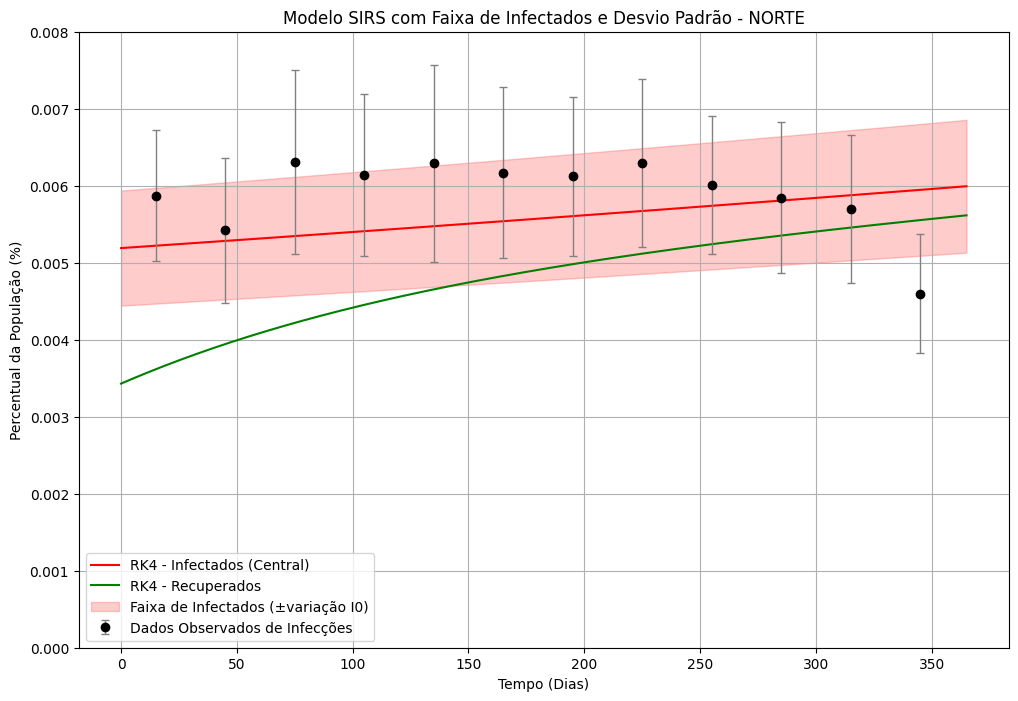

Região: NORDESTE
Erro Médio Absoluto (MAE): 0.000285
Erro Quadrático Médio (MSE): 0.000000
Raiz do Erro Quadrático Médio (RMSE): 0.000438
Erro Médio Percentual Absoluto (MAPE): 9.05%

Gráfico salvo em: NORDESTE_SIRS_plot.png


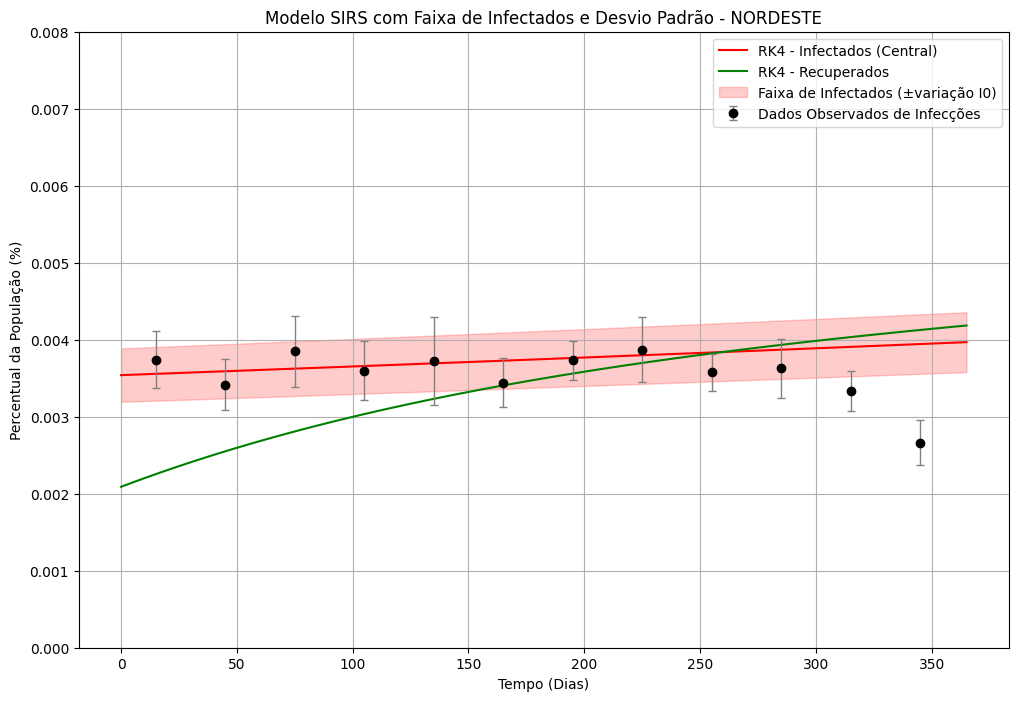

Região: SUDESTE
Erro Médio Absoluto (MAE): 0.000349
Erro Quadrático Médio (MSE): 0.000000
Raiz do Erro Quadrático Médio (RMSE): 0.000476
Erro Médio Percentual Absoluto (MAPE): 9.40%

Gráfico salvo em: SUDESTE_SIRS_plot.png


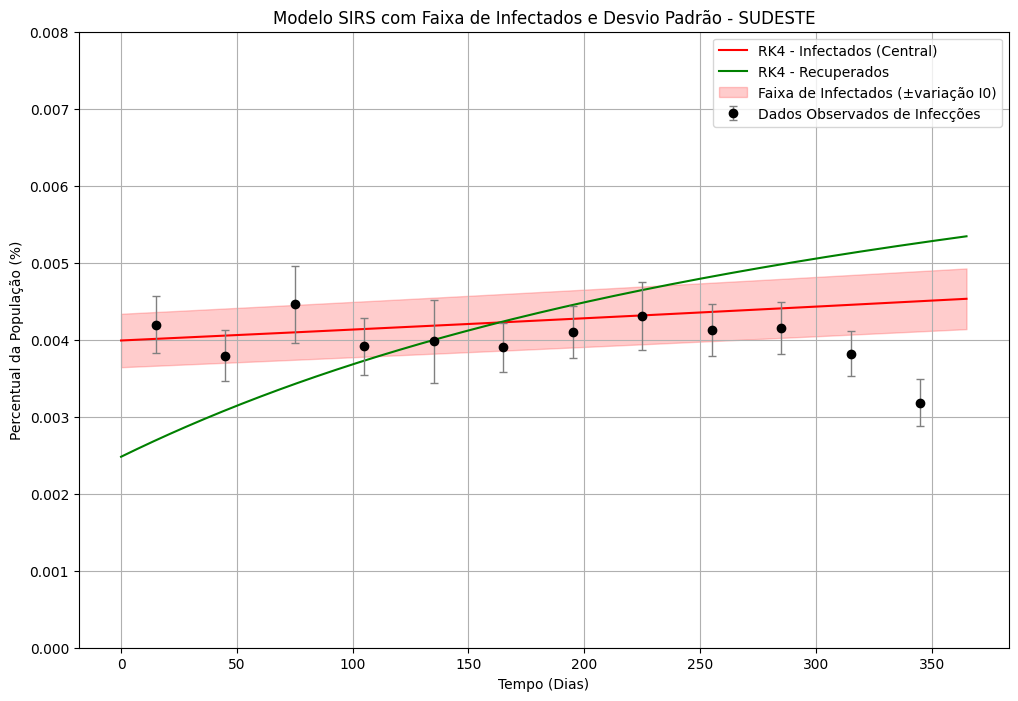

Região: SUL
Erro Médio Absoluto (MAE): 0.000225
Erro Quadrático Médio (MSE): 0.000000
Raiz do Erro Quadrático Médio (RMSE): 0.000323
Erro Médio Percentual Absoluto (MAPE): 7.76%

Gráfico salvo em: SUL_SIRS_plot.png


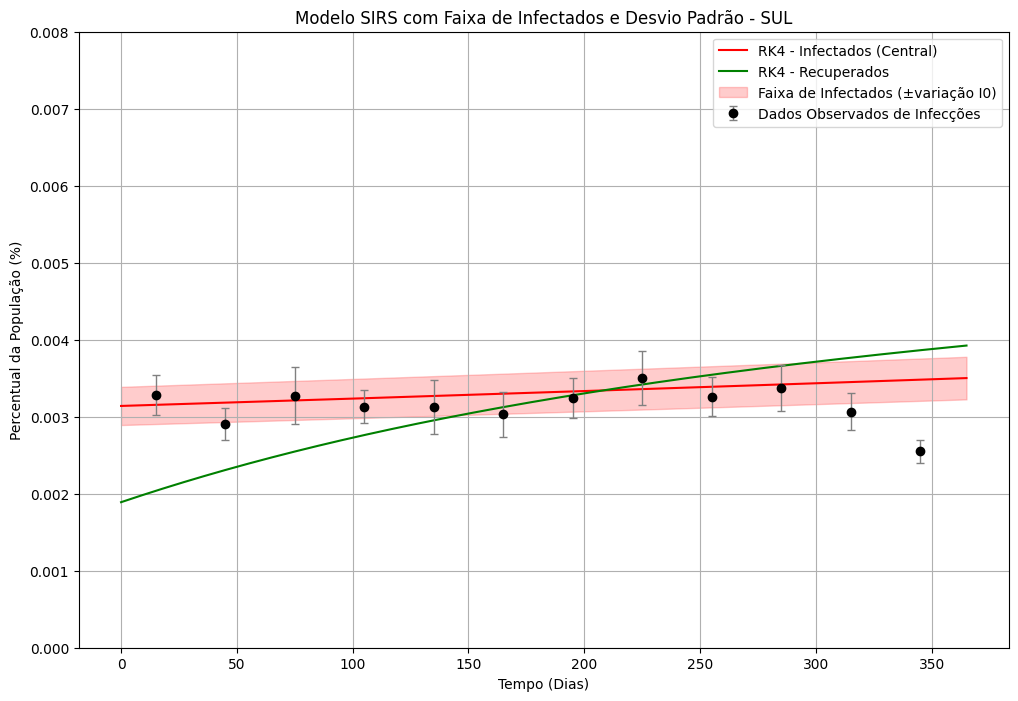

Região: CENTROOESTE
Erro Médio Absoluto (MAE): 0.000199
Erro Quadrático Médio (MSE): 0.000000
Raiz do Erro Quadrático Médio (RMSE): 0.000313
Erro Médio Percentual Absoluto (MAPE): 9.55%

Gráfico salvo em: CENTROOESTE_SIRS_plot.png


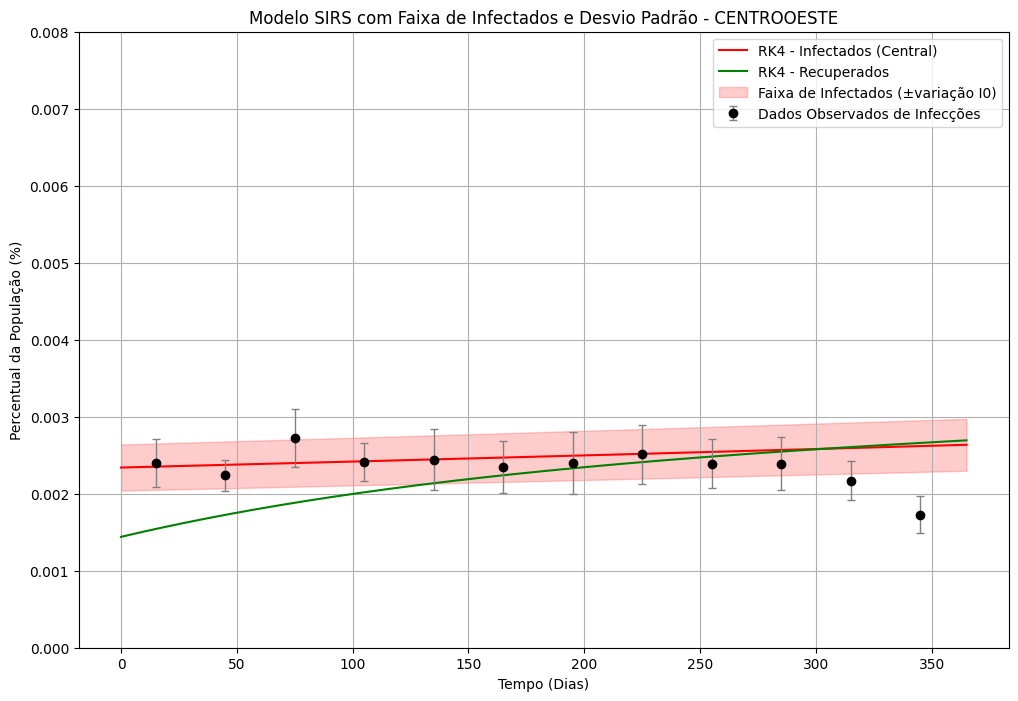

In [12]:
# Criando gráficos para cada região com os pontos de dados observados nos dias de medição
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a região atual
    variacao_I0 = variacao_I0_valores[regiao]  # Variação de I0 para a região atual

    # Definindo dois valores de I0 para criar a faixa (±variação_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o método RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(
        S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Executando o método RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(
        S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Executando o método RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(
        S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # --- Aqui começa a inclusão das métricas de erro ---

    # Interpolando os valores de I_rk4 nos dias de medição
    I_modelo_medicao = [I_rk4[int(dia / dt)] for dia in dias_medicao]

    # Convertendo listas em arrays numpy para facilitar os cálculos
    I_modelo_medicao = np.array(I_modelo_medicao)
    I_observado = np.array(media_casos_percentual[regiao])

    # Calculando o MAE
    mae = mean_absolute_error(I_observado, I_modelo_medicao)

    # Calculando o MSE
    mse = mean_squared_error(I_observado, I_modelo_medicao)

    # Calculando o RMSE
    rmse = np.sqrt(mse)

    # Calculando o Erro Médio Percentual Absoluto (MAPE)
    mape = np.mean(np.abs((I_observado - I_modelo_medicao) / I_observado)) * 100

    # Exibindo as métricas
    print(f'Região: {regiao}')
    print(f'Erro Médio Absoluto (MAE): {mae:.6f}')
    print(f'Erro Quadrático Médio (MSE): {mse:.6f}')
    print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse:.6f}')
    print(f'Erro Médio Percentual Absoluto (MAPE): {mape:.2f}%\n')

    # --- Fim das métricas de erro ---

    # (Restante do código para plotar os gráficos)
    # Plotando os resultados
    plt.figure(figsize=(12, 8))

    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')

    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high,
                     color='red', alpha=0.2, label='Faixa de Infectados (±variação I0)')

    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao,
        media_casos_percentual[regiao],
        yerr=desvio_padrao_casos_percentual[regiao],
        fmt='o',
        color='black',
        ecolor='gray',
        elinewidth=1,
        capsize=3,
        label='Dados Observados de Infecções',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)

    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da População (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padrão - {regiao}')
    plt.legend()
    plt.grid(True)
    # Salvar o gráfico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gráfico salvo em: {filename}')

    # Exibir o gráfico
    plt.show()

Interpretando os resultados:

Erro Médio Absoluto (MAE): Indica, em média, o quanto as previsões do modelo diferem dos dados observados. Valores menores indicam melhor desempenho.

Erro Quadrático Médio (MSE) e Raiz do Erro Quadrático Médio (RMSE): MSE penaliza erros maiores de forma mais intensa devido ao quadrado das diferenças. O RMSE traz o erro para as mesmas unidades das observações, facilitando a interpretação.

Erro Médio Percentual Absoluto (MAPE): Expressa o erro como uma porcentagem dos valores observados, permitindo avaliar o desempenho relativo do modelo.

Acurácia e Precisão:

Acurácia: Se os erros (MAE, MSE, RMSE) são baixos, podemos dizer que o modelo é acurado, ou seja, ele consegue prever valores próximos aos observados.

Precisão: Se ao variar os parâmetros iniciais (como a variação de I0 que você já implementou), o modelo apresenta pequenas variações nas previsões, ele é considerado preciso. A faixa de infectados que você plotou no gráfico já dá uma ideia da precisão do modelo.

Erro Médio Absoluto (MAE):

Representa a média das diferenças absolutas entre os valores previstos pelo modelo e os valores observados nos dados.
Valores menores de MAE indicam que as previsões do modelo estão mais próximas dos dados reais.
No seu caso, o MAE varia de aproximadamente 0.000199 (Centro-Oeste) a 0.000575 (Norte).
Erro Quadrático Médio (MSE) e Raiz do Erro Quadrático Médio (RMSE):

O MSE é a média dos quadrados das diferenças entre previsões e observações. O RMSE é a raiz quadrada do MSE.
Eles penalizam erros maiores de forma mais intensa devido ao quadrado das diferenças.
Valores menores indicam melhor desempenho do modelo.
Os valores de RMSE seguem a mesma tendência do MAE.
Erro Médio Percentual Absoluto (MAPE):

Indica o erro médio em termos percentuais, facilitando a interpretação relativa do erro.
No seu caso, o MAPE varia de aproximadamente 7.76% (Sul) a 9.99% (Norte).
Um MAPE de 9.99% significa que, em média, as previsões do modelo para a região Norte diferem dos dados reais em cerca de 9.99%.
Interpretação para cada região:

Norte:

MAE mais alto (0.000575) e MAPE mais alto (9.99%).
Isso indica que, comparativamente, o modelo teve um desempenho menos preciso nesta região.
Possíveis razões podem incluir variabilidades não capturadas pelo modelo ou parâmetros que precisam ser ajustados.
Nordeste:

MAE e MAPE ligeiramente menores que o Norte.
O modelo se ajusta um pouco melhor aqui, mas ainda há espaço para melhorias.
Sudeste:

Valores intermediários de erro.
O desempenho do modelo é razoável, mas pode ser aprimorado com ajustes nos parâmetros ou incluindo outros fatores relevantes.
Sul:

MAE e MAPE mais baixos entre todas as regiões (MAE: 0.000225, MAPE: 7.76%).
Indica que o modelo está representando os dados desta região com maior precisão.
O menor erro percentual sugere que os parâmetros do modelo estão bem ajustados para esta região ou que a dinâmica da doença é mais consistente com as suposições do modelo.
Centro-Oeste:

MAE mais baixo (0.000199) e MAPE relativamente baixo (9.55%).
Embora o MAPE seja um pouco mais alto que o do Sul, o MAE é o menor entre todas as regiões.
Isso sugere que, em termos absolutos, o modelo está prevendo muito bem nesta região.
Considerações Gerais:

Comparação entre Regiões:

O modelo apresenta melhor desempenho nas regiões Sul e Centro-Oeste, indicando que ele está mais bem calibrado ou que as características epidemiológicas dessas regiões são melhor capturadas pelo modelo.
Nas regiões Norte, Nordeste e Sudeste, o modelo tem erros ligeiramente maiores, sugerindo a necessidade de refinamento.
Valores de Erro:

MAE e RMSE baixos: Os valores são inferiores a 0.001, o que indica que, em termos absolutos, o erro é pequeno.
MAPE entre 7% e 10%: Isso significa que, em média, as previsões do modelo estão dentro de 7% a 10% dos valores observados, o que é aceitável em muitos contextos epidemiológicos.
Interpretação do MAPE:

Um MAPE abaixo de 10% é geralmente considerado bom em modelos preditivos.
No entanto, para epidemiologia, onde pequenas diferenças podem significar grandes impactos na saúde pública, pode ser desejável reduzir ainda mais esse erro.

Desempenho Geral:

O modelo SIRS aplicado apresenta um desempenho razoável, com erros médios percentuais absolutos entre 7.76% e 9.99%.
Isso indica que o modelo está capturando a tendência geral da propagação da doença em cada região.

# Usando beta_intrinseco no lugar do beta no modelo SIRS

Gráfico salvo em: NORTE_SIRS_beta_intrinseco_plot.png


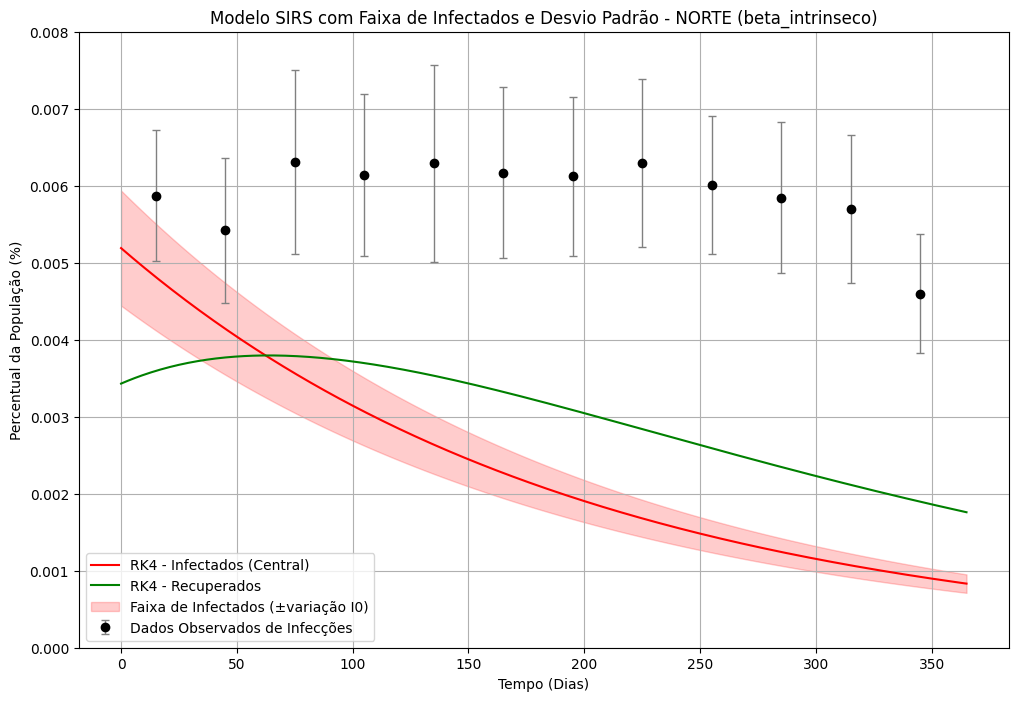

Gráfico salvo em: NORDESTE_SIRS_beta_intrinseco_plot.png


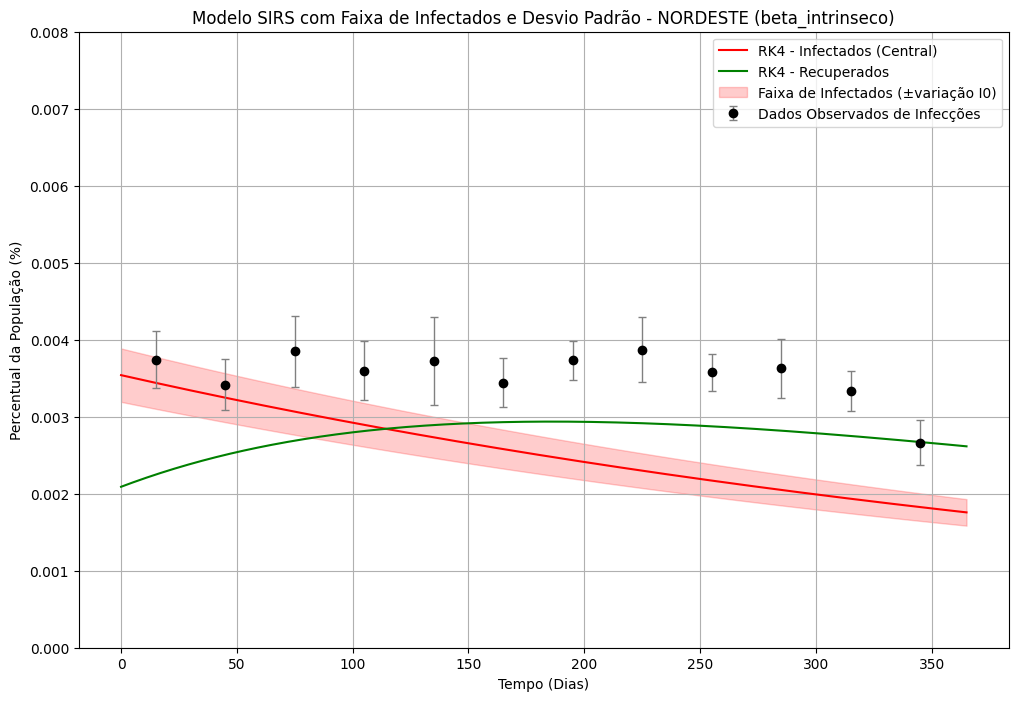

Gráfico salvo em: SUDESTE_SIRS_beta_intrinseco_plot.png


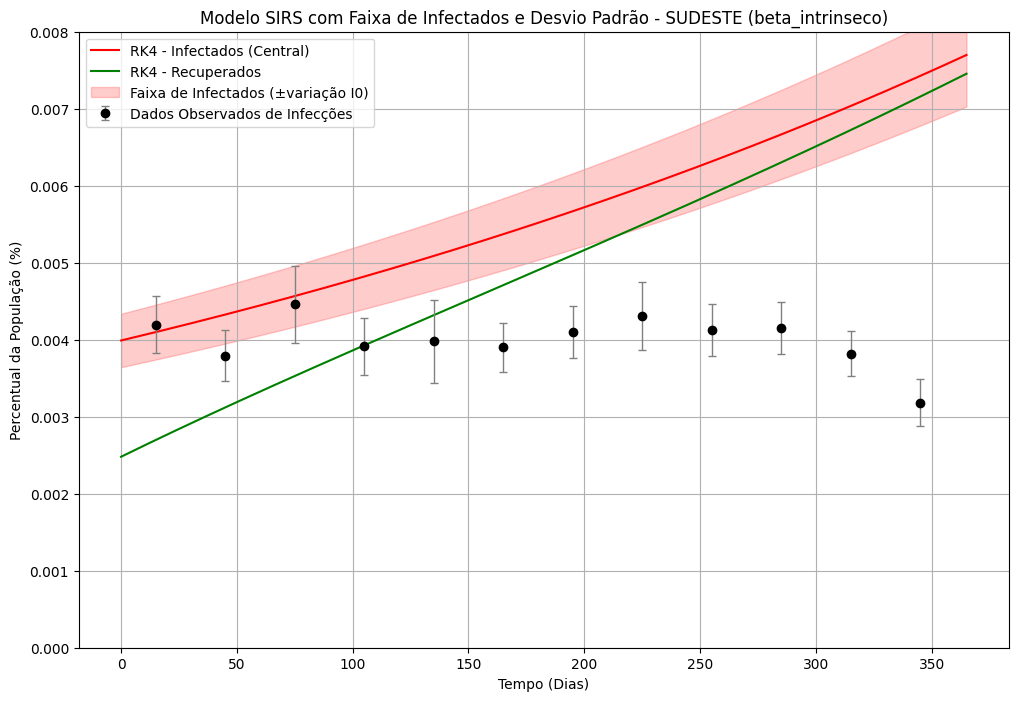

Gráfico salvo em: SUL_SIRS_beta_intrinseco_plot.png


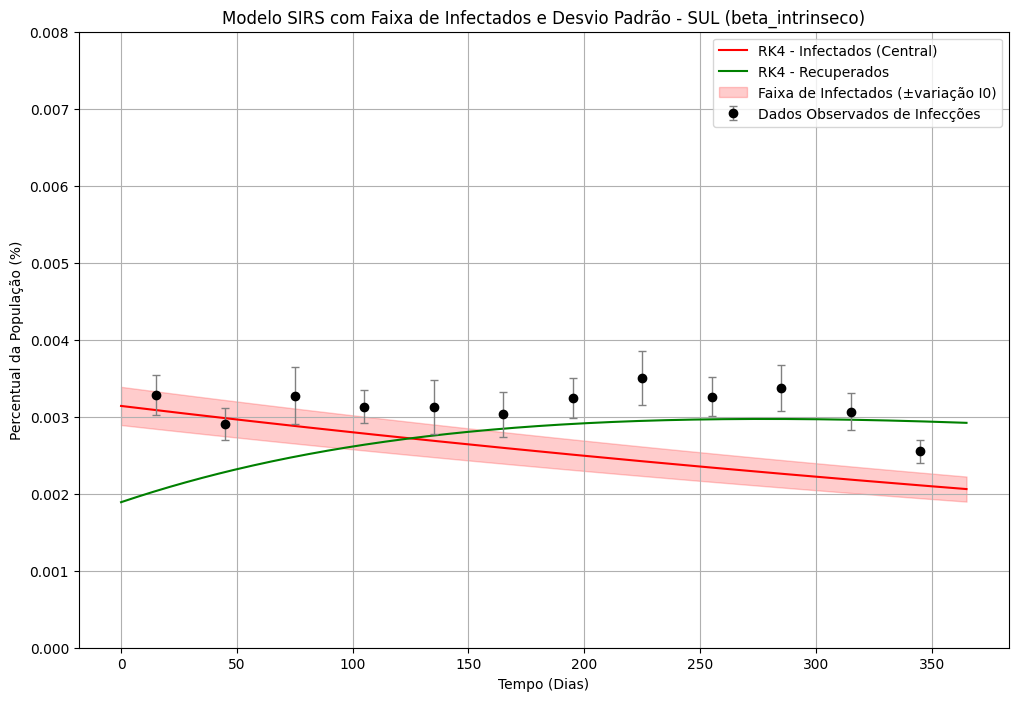

Gráfico salvo em: CENTROOESTE_SIRS_beta_intrinseco_plot.png


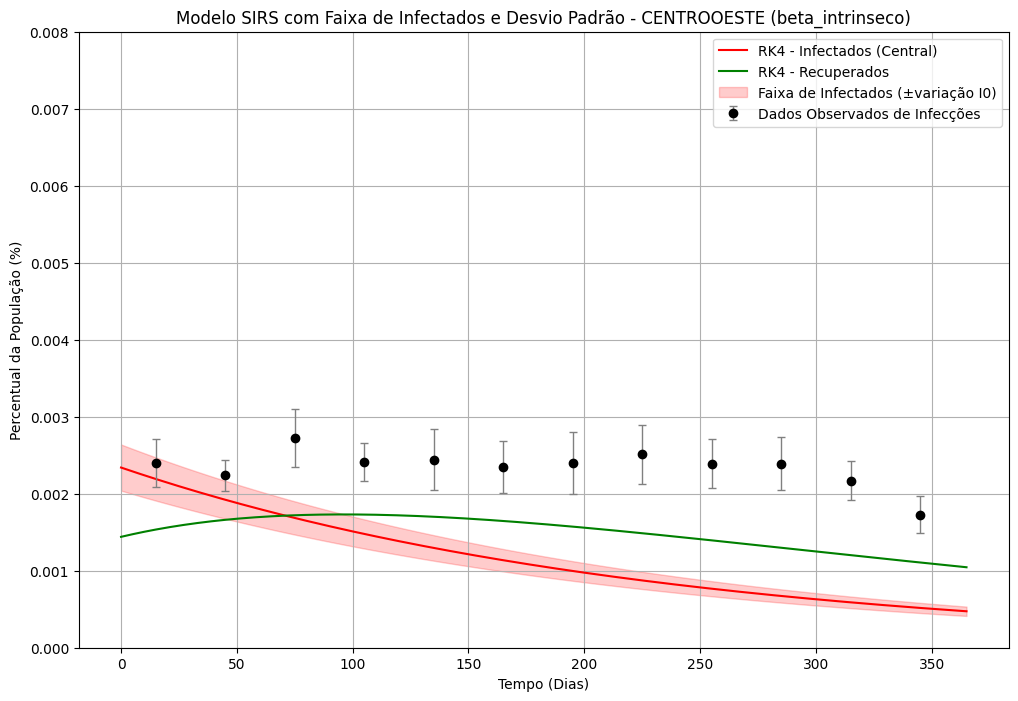

In [13]:
# Função para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equações SIRS.
    
    Parâmetros:
    - S: População suscetível (%)
    - I: População infectada (%)
    - R: População recuperada (%)
    - beta_f: Taxa de transmissão
    - gamma_f: Taxa de recuperação
    - mu_s: Taxa de mortalidade natural (suscetíveis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na população
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscetíveis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# Método de Runge-Kutta de 4ª Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max + dt, dt)  # Inclui t_max
    S_results, I_results, R_results = [S0], [I0], [R0]

    for _ in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6  # Correção aqui

        # Normalização para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)

    return times, S_results, I_results, R_results

# Parâmetros de simulação
t_max = 365  # Tempo máximo de simulação (dias)
dt = 1       # Tamanho do passo de tempo (dias)

# Definindo os valores de beta para cada região "β_intrínseco": [0.008571, 0.010071, 0.013191, 0.010138, 0.007912]
beta_valores = {
    'NORTE': 0.008571,
    'NORDESTE': 0.010071,
    'SUDESTE': 0.013191,
    'SUL': 0.010138,
    'CENTROOESTE': 0.007912
}

# Definindo os valores de gamma para cada região
gamma_valores = {
    'NORTE': 0.0073,
    'NORDESTE': 0.0064,
    'SUDESTE': 0.0068,
    'SUL': 0.006,
    'CENTROOESTE': 0.0067
}

# Definindo os valores de mu_i para cada região
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada região
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada região
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada região
xi_valores = {
    'NORTE': 0.0073 / 2,
    'NORDESTE': 0.0064 / 2,
    'SUDESTE': 0.0068 / 2,
    'SUL': 0.006 / 2,
    'CENTROOESTE': 0.0067 / 2
}

# Definindo os valores iniciais de S, I e R para cada região
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de média de casos em percentual para cada região
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dados de desvio padrão de casos em percentual para cada região
desvio_padrao_casos_percentual = {
    'NORTE': [0.00085, 0.00094, 0.00119, 0.00105, 0.00128, 0.00111, 0.00103, 0.00109, 0.0009, 0.00098, 0.00096, 0.00077],
    'NORDESTE': [0.00037, 0.00033, 0.00046, 0.00038, 0.00057, 0.00032, 0.00025, 0.00042, 0.00024, 0.00038, 0.00026, 0.00029],
    'SUDESTE': [0.00037, 0.00033, 0.0005, 0.00037, 0.00054, 0.00032, 0.00034, 0.00044, 0.00034, 0.00034, 0.00029, 0.00031],
    'SUL': [0.00026, 0.00021, 0.00037, 0.00022, 0.00035, 0.00029, 0.00026, 0.00035, 0.00025, 0.0003, 0.00024, 0.00015],
    'CENTROOESTE': [0.00031, 0.0002, 0.00038, 0.00025, 0.0004, 0.00034, 0.0004, 0.00038, 0.00032, 0.00035, 0.00025, 0.00024]
}

# Definindo a variação de I0 para cada região (porcentagem decimal, ex: 0.144 para 14.4%)
variacao_I0_valores = {
    'NORTE': 0.144,
    'NORDESTE': 0.098,
    'SUDESTE': 0.087,
    'SUL': 0.079,
    'CENTROOESTE': 0.128
}

# Criando gráficos para cada região
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medição
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Definindo limites do eixo Y
y_min = 0
y_max = 0.008  # 1%

# Criando gráficos para cada região com os pontos de dados observados nos dias de medição
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a região atual
    variacao_I0 = variacao_I0_valores[regiao]  # Variação de I0 para a região atual

    # Definindo dois valores de I0 para criar a faixa (±variação_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o método RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o método RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o método RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    
    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high, color='red', alpha=0.2, label='Faixa de Infectados (±variação I0)')
    
    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao, 
        media_casos_percentual[regiao], 
        yerr=desvio_padrao_casos_percentual[regiao], 
        fmt='o', 
        color='black', 
        ecolor='gray', 
        elinewidth=1, 
        capsize=3, 
        label='Dados Observados de Infecções',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)
    
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da População (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padrão - {regiao} (beta_intrinseco)')
    plt.legend()
    plt.grid(True)
    # Salvar o gráfico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_beta_intrinseco_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gráfico salvo em: {filename}')
    
    # Exibir o gráfico
    plt.show()

# Usando gamma_intrinseco no lugar do gamma no modelo SIRS

Gráfico salvo em: NORTE_SIRS_gamma_intrinseco_plot.png


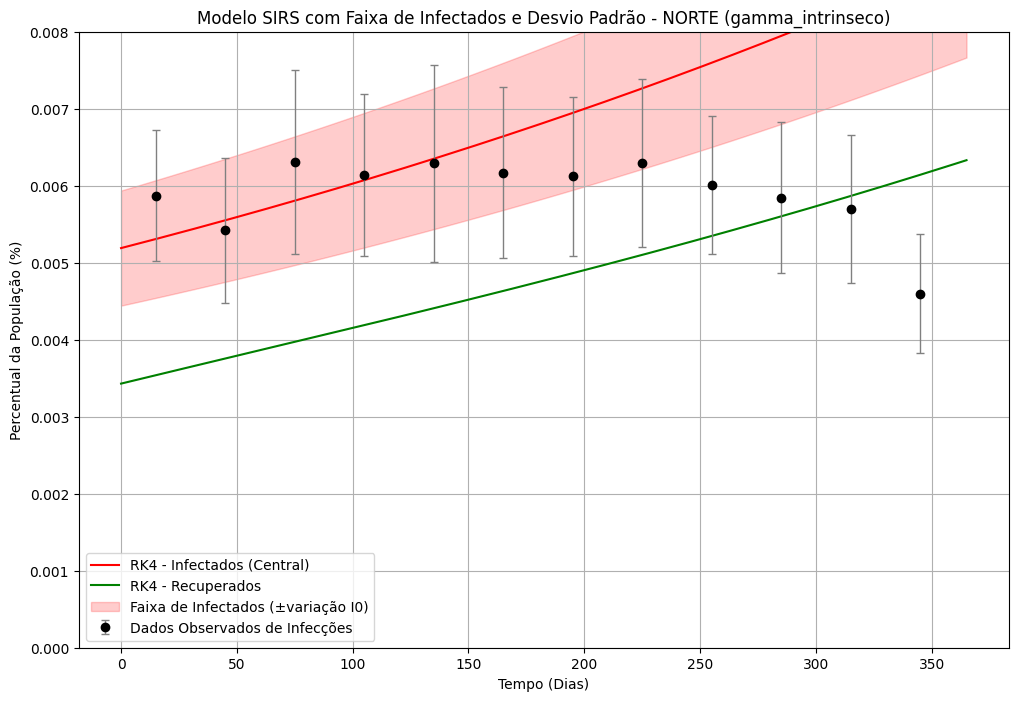

Gráfico salvo em: NORDESTE_SIRS_gamma_intrinseco_plot.png


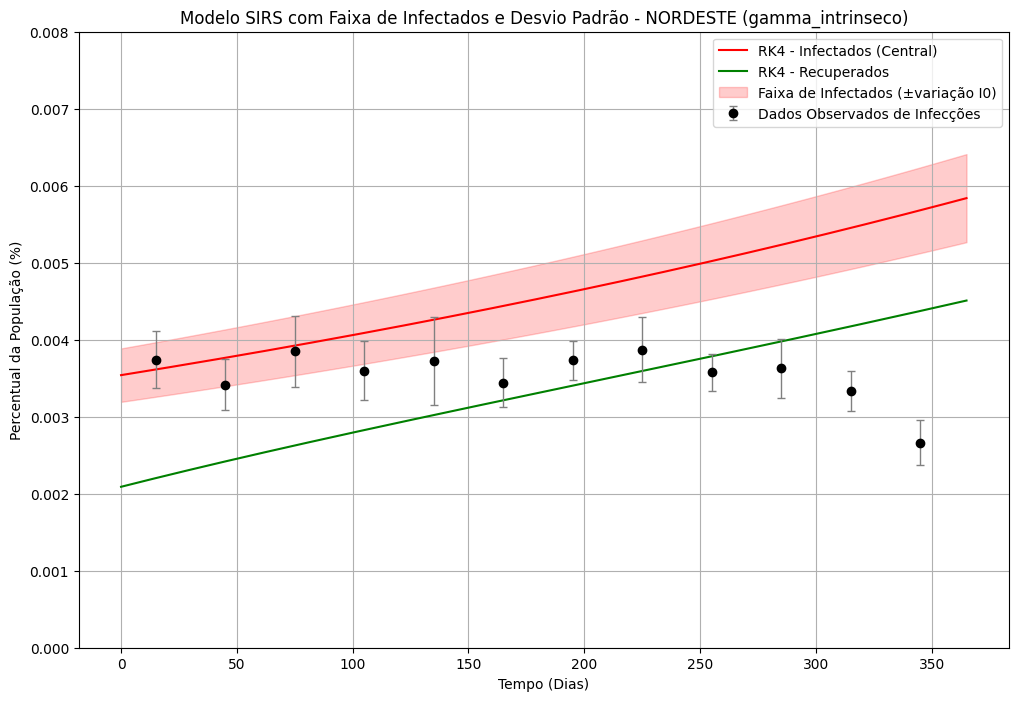

Gráfico salvo em: SUDESTE_SIRS_gamma_intrinseco_plot.png


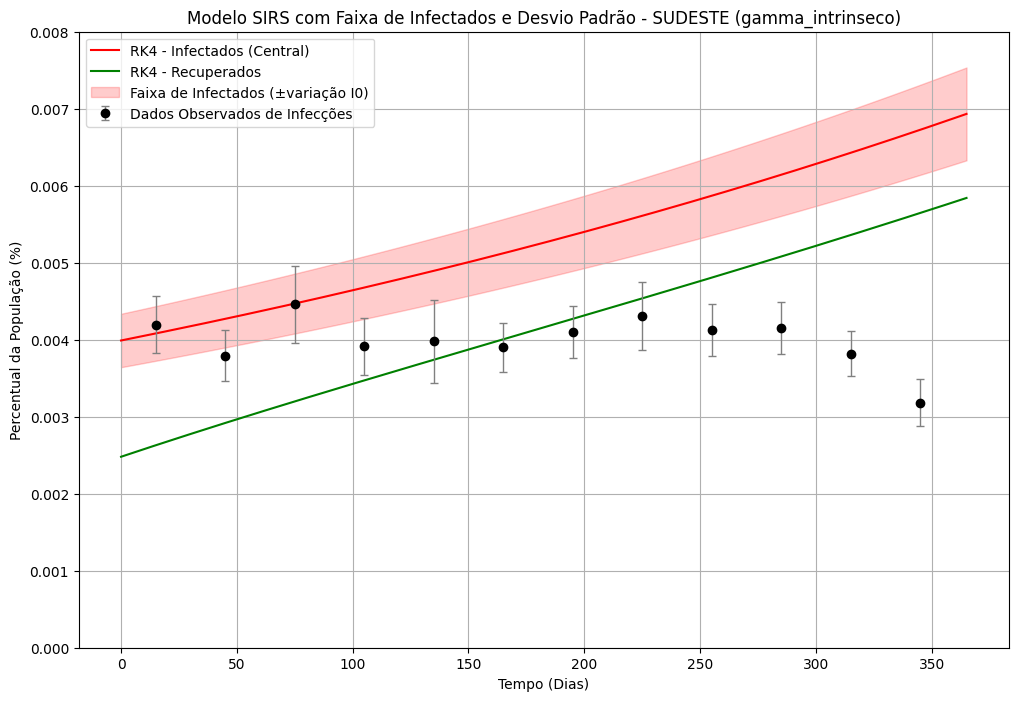

Gráfico salvo em: SUL_SIRS_gamma_intrinseco_plot.png


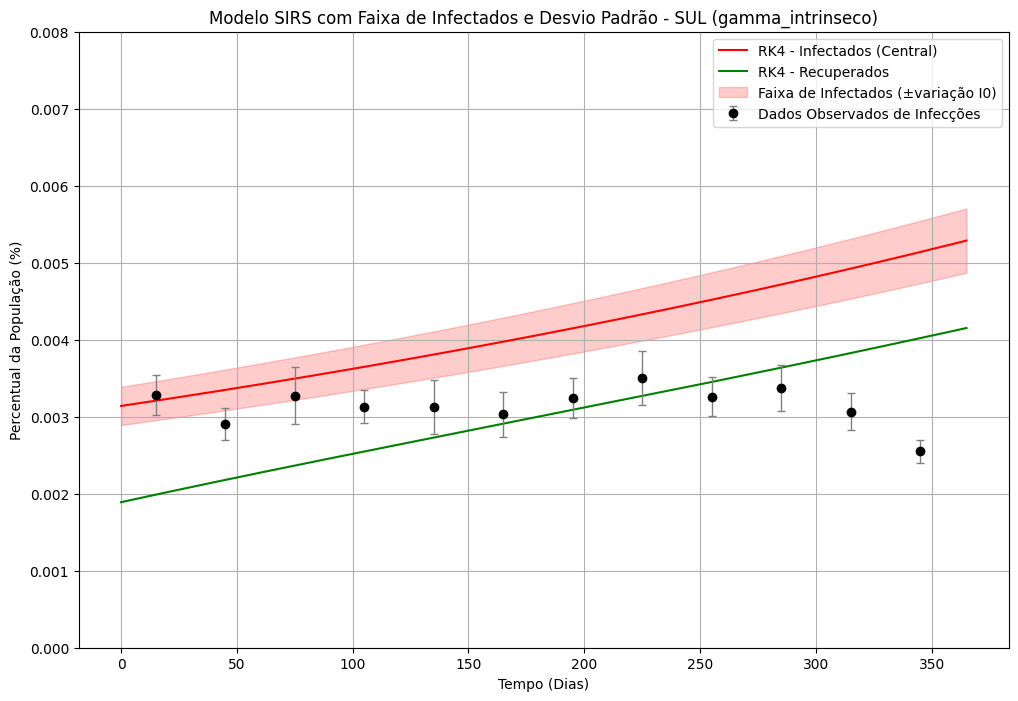

Gráfico salvo em: CENTROOESTE_SIRS_gamma_intrinseco_plot.png


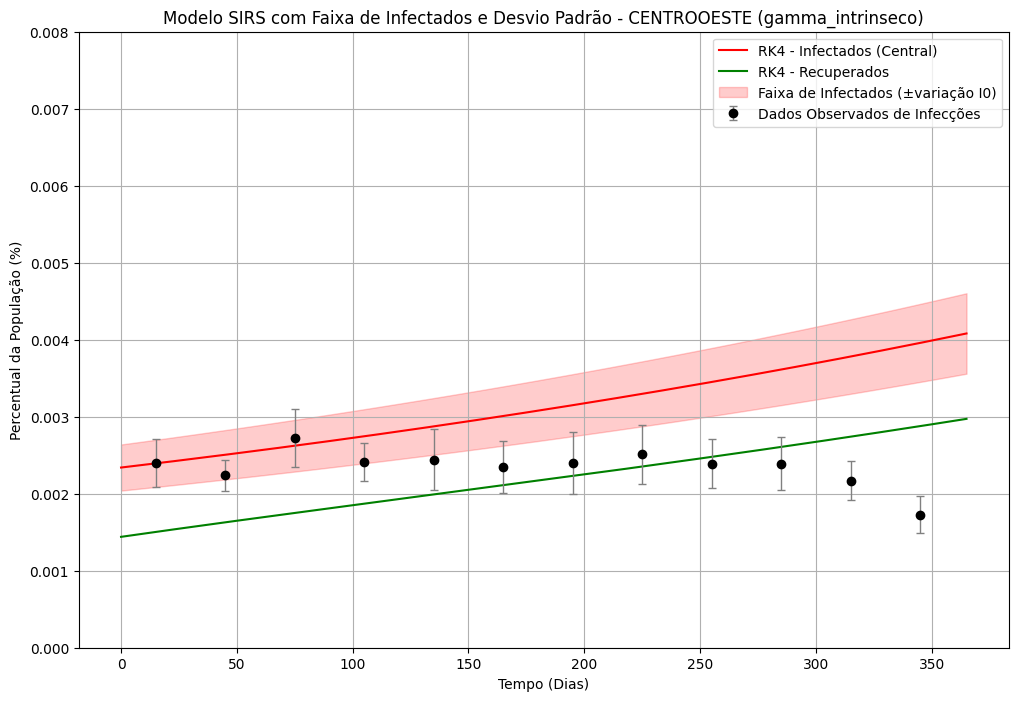

In [14]:
# Função para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equações SIRS.
    
    Parâmetros:
    - S: População suscetível (%)
    - I: População infectada (%)
    - R: População recuperada (%)
    - beta_f: Taxa de transmissão
    - gamma_f: Taxa de recuperação
    - mu_s: Taxa de mortalidade natural (suscetíveis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na população
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscetíveis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# Método de Runge-Kutta de 4ª Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max + dt, dt)  # Inclui t_max
    S_results, I_results, R_results = [S0], [I0], [R0]

    for _ in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6  # Correção aqui

        # Normalização para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)

    return times, S_results, I_results, R_results

# Parâmetros de simulação
t_max = 365  # Tempo máximo de simulação (dias)
dt = 1       # Tamanho do passo de tempo (dias)

# Definindo os valores de beta para cada região
beta_valores = {
    'NORTE': 0.01397,
    'NORDESTE': 0.0123,
    'SUDESTE': 0.01174,
    'SUL': 0.01159,
    'CENTROOESTE': 0.01261
}

# Definindo os valores de gamma para cada região
gamma_valores = {
    'NORTE': 0.006200,
    'NORDESTE': 0.005342,
    'SUDESTE': 0.005635,
    'SUL': 0.004871,
    'CENTROOESTE': 0.005502
}

# Definindo os valores de mu_i para cada região
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada região
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada região
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada região
xi_valores = {
    'NORTE': 0.0073 / 2,
    'NORDESTE': 0.0064 / 2,
    'SUDESTE': 0.0068 / 2,
    'SUL': 0.006 / 2,
    'CENTROOESTE': 0.0067 / 2
}

# Definindo os valores iniciais de S, I e R para cada região
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de média de casos em percentual para cada região
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dados de desvio padrão de casos em percentual para cada região
desvio_padrao_casos_percentual = {
    'NORTE': [0.00085, 0.00094, 0.00119, 0.00105, 0.00128, 0.00111, 0.00103, 0.00109, 0.0009, 0.00098, 0.00096, 0.00077],
    'NORDESTE': [0.00037, 0.00033, 0.00046, 0.00038, 0.00057, 0.00032, 0.00025, 0.00042, 0.00024, 0.00038, 0.00026, 0.00029],
    'SUDESTE': [0.00037, 0.00033, 0.0005, 0.00037, 0.00054, 0.00032, 0.00034, 0.00044, 0.00034, 0.00034, 0.00029, 0.00031],
    'SUL': [0.00026, 0.00021, 0.00037, 0.00022, 0.00035, 0.00029, 0.00026, 0.00035, 0.00025, 0.0003, 0.00024, 0.00015],
    'CENTROOESTE': [0.00031, 0.0002, 0.00038, 0.00025, 0.0004, 0.00034, 0.0004, 0.00038, 0.00032, 0.00035, 0.00025, 0.00024]
}

# Definindo a variação de I0 para cada região (porcentagem decimal, ex: 0.144 para 14.4%)
variacao_I0_valores = {
    'NORTE': 0.144,
    'NORDESTE': 0.098,
    'SUDESTE': 0.087,
    'SUL': 0.079,
    'CENTROOESTE': 0.128
}

# Criando gráficos para cada região
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medição
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Definindo limites do eixo Y
y_min = 0
y_max = 0.008  # 1%

# Criando gráficos para cada região com os pontos de dados observados nos dias de medição
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a região atual
    variacao_I0 = variacao_I0_valores[regiao]  # Variação de I0 para a região atual

    # Definindo dois valores de I0 para criar a faixa (±variação_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o método RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o método RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o método RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    
    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high, color='red', alpha=0.2, label='Faixa de Infectados (±variação I0)')
    
    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao, 
        media_casos_percentual[regiao], 
        yerr=desvio_padrao_casos_percentual[regiao], 
        fmt='o', 
        color='black', 
        ecolor='gray', 
        elinewidth=1, 
        capsize=3, 
        label='Dados Observados de Infecções',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)
    
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da População (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padrão - {regiao} (gamma_intrinseco)')
    plt.legend()
    plt.grid(True)
    # Salvar o gráfico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_gamma_intrinseco_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gráfico salvo em: {filename}')
    
    # Exibir o gráfico
    plt.show()

# Usando beta_intrinseco e gamma_intrinseco no lugar do beta e gamma no modelo SIRS

Gráfico salvo em: NORTE_SIRS_beta_e_gamma_intrinsecos_plot.png


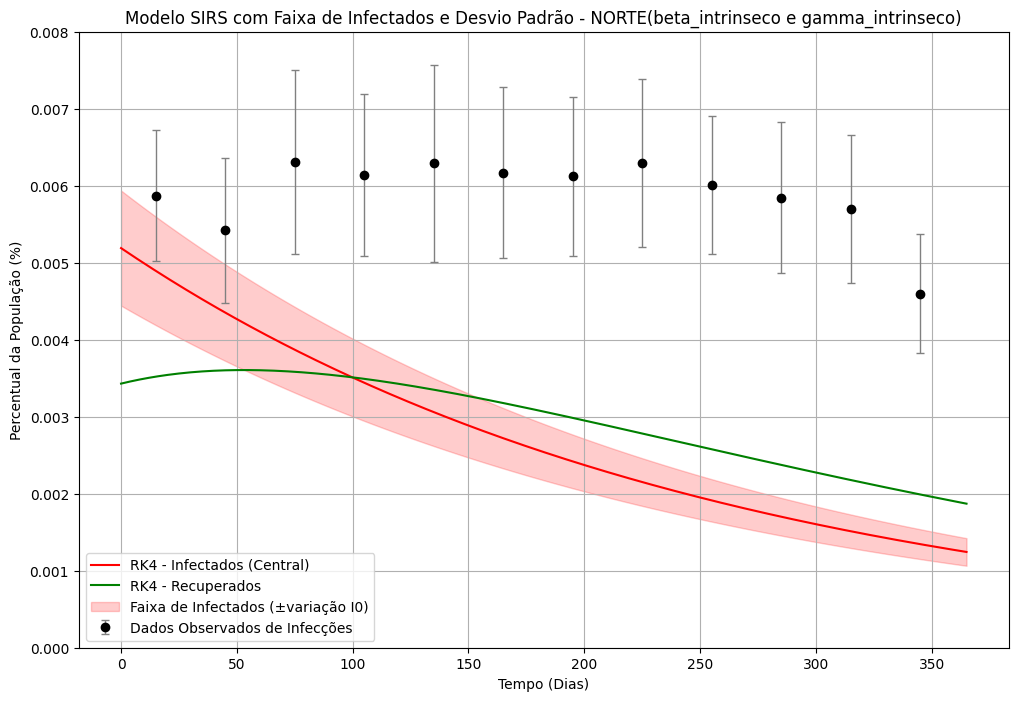

Gráfico salvo em: NORDESTE_SIRS_beta_e_gamma_intrinsecos_plot.png


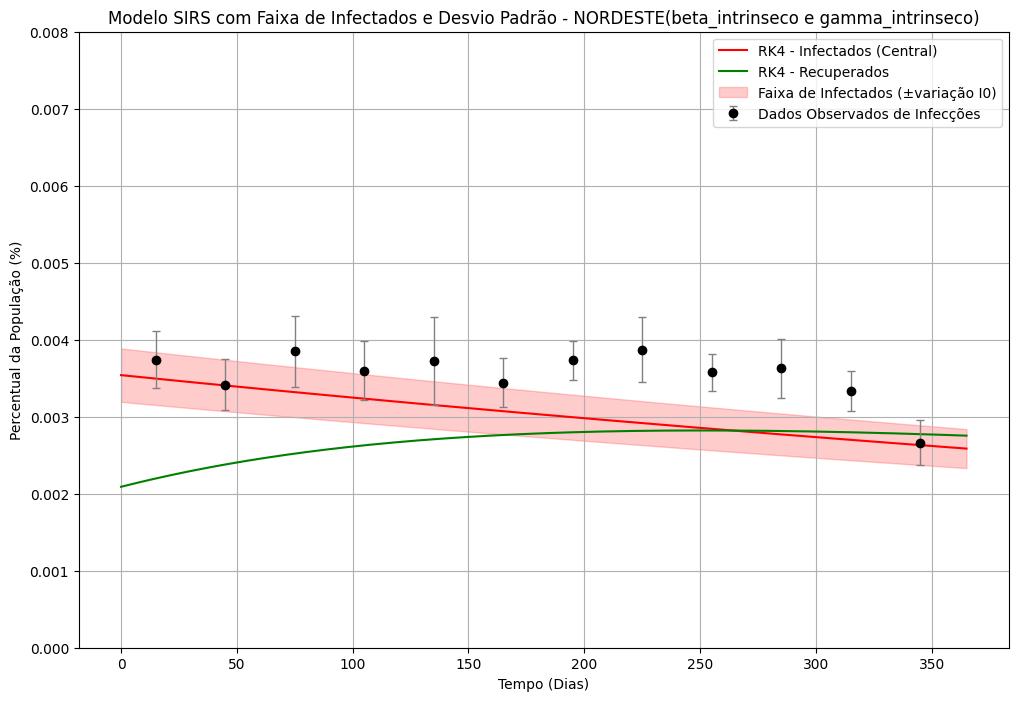

Gráfico salvo em: SUDESTE_SIRS_beta_e_gamma_intrinsecos_plot.png


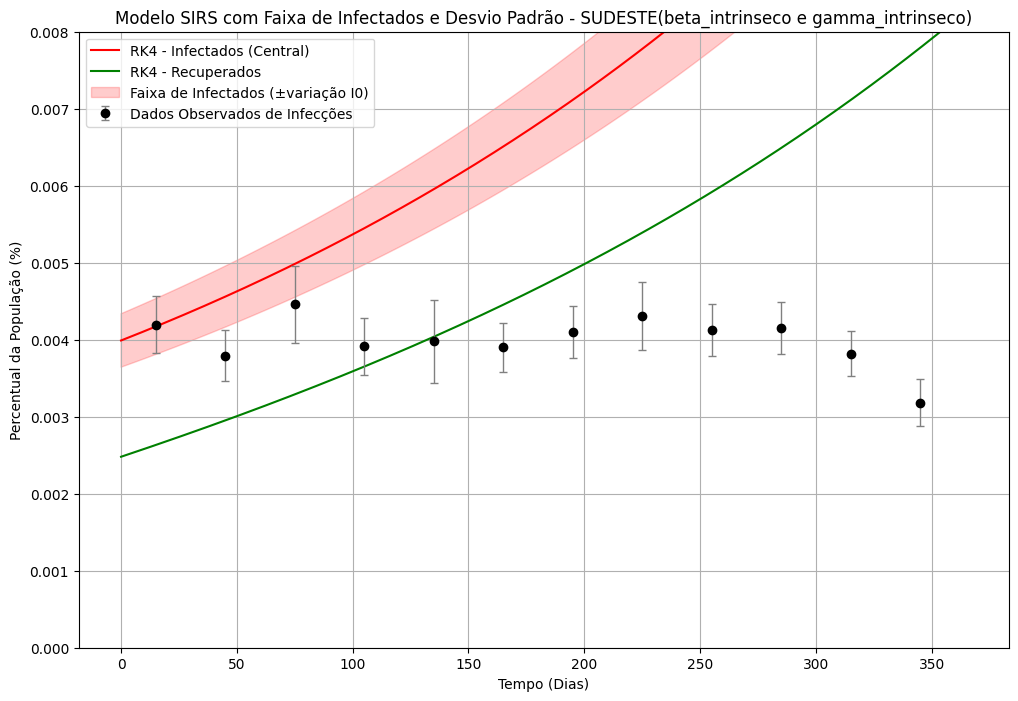

Gráfico salvo em: SUL_SIRS_beta_e_gamma_intrinsecos_plot.png


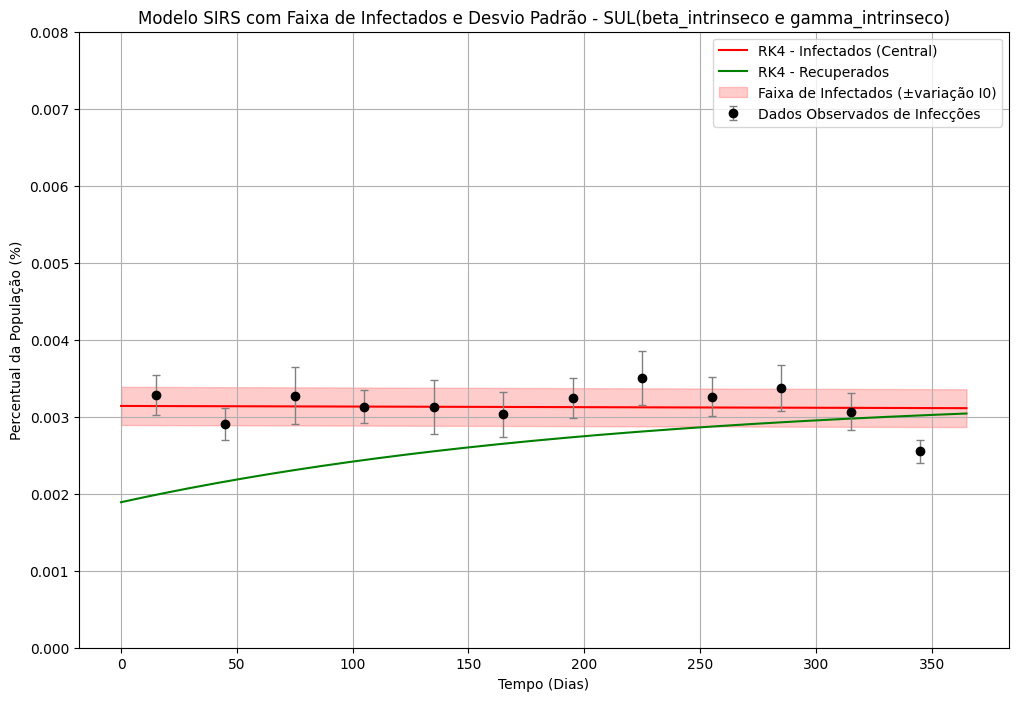

Gráfico salvo em: CENTROOESTE_SIRS_beta_e_gamma_intrinsecos_plot.png


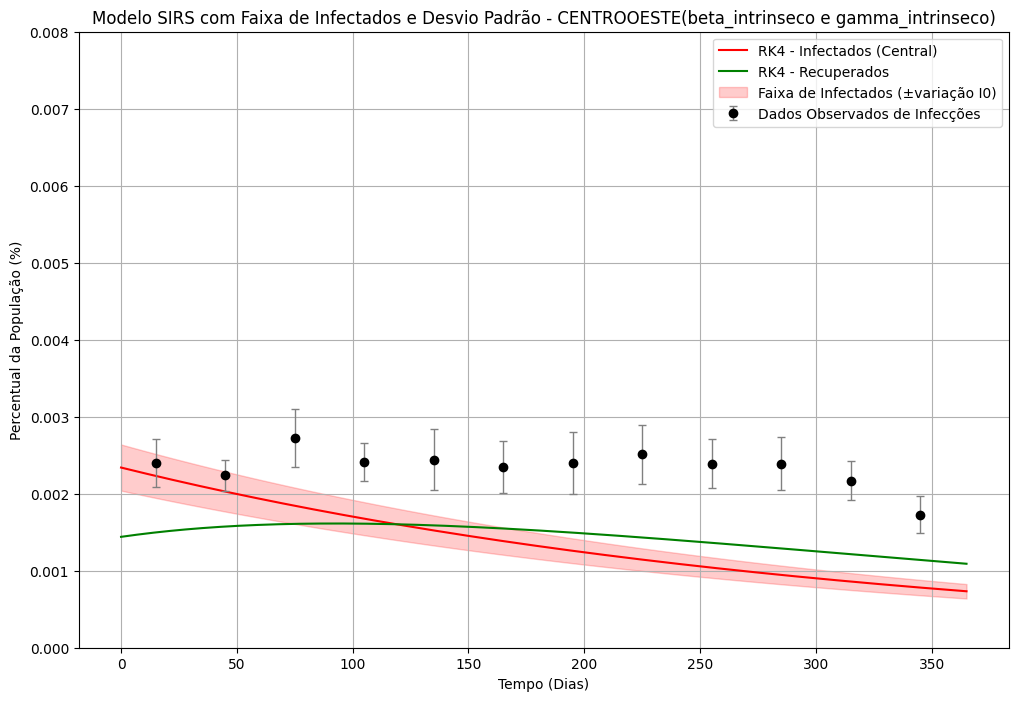

In [15]:
# Função para criar o modelo SIRS
def SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    """
    Sistema de Equações SIRS.
    
    Parâmetros:
    - S: População suscetível (%)
    - I: População infectada (%)
    - R: População recuperada (%)
    - beta_f: Taxa de transmissão
    - gamma_f: Taxa de recuperação
    - mu_s: Taxa de mortalidade natural (suscetíveis)
    - mu_i: Taxa de mortalidade natural (infectados)
    - eta: Taxa de entrada na população
    - xi: Taxa de perda de imunidade (recuperados voltando a ser suscetíveis)
    
    Retorna:
    - dS_dt, dI_dt, dR_dt: Derivadas de S, I e R
    """
    dS_dt = (-beta_f * S * I / 100) + (eta - mu_s) * S + xi * R
    dI_dt = (beta_f * S * I / 100) - gamma_f * I - mu_i * I
    dR_dt = gamma_f * I - xi * R
    return dS_dt, dI_dt, dR_dt

# Método de Runge-Kutta de 4ª Ordem para SIRS
def rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi):
    S, I, R = S0, I0, R0
    times = np.arange(0, t_max + dt, dt)  # Inclui t_max
    S_results, I_results, R_results = [S0], [I0], [R0]

    for _ in times[1:]:
        dS1, dI1, dR1 = SIRS_odes(S, I, R, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS2, dI2, dR2 = SIRS_odes(S + dS1 * dt / 2, I + dI1 * dt / 2, R + dR1 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS3, dI3, dR3 = SIRS_odes(S + dS2 * dt / 2, I + dI2 * dt / 2, R + dR2 * dt / 2, beta_f, gamma_f, mu_s, mu_i, eta, xi)
        dS4, dI4, dR4 = SIRS_odes(S + dS3 * dt, I + dI3 * dt, R + dR3 * dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

        S += (dS1 + 2 * dS2 + 2 * dS3 + dS4) * dt / 6
        I += (dI1 + 2 * dI2 + 2 * dI3 + dI4) * dt / 6
        R += (dR1 + 2 * dR2 + 2 * dR3 + dR4) * dt / 6  # Correção aqui

        # Normalização para garantir que S + I + R = 100%
        total = S + I + R
        S, I, R = 100 * S / total, 100 * I / total, 100 * R / total

        S_results.append(S)
        I_results.append(I)
        R_results.append(R)

    return times, S_results, I_results, R_results

# Parâmetros de simulação
t_max = 365  # Tempo máximo de simulação (dias)
dt = 1       # Tamanho do passo de tempo (dias)

# Definindo os valores de beta para cada região
beta_valores = {
    'NORTE': 0.008571,
    'NORDESTE': 0.010071,
    'SUDESTE': 0.013191,
    'SUL': 0.010138,
    'CENTROOESTE': 0.007912
}

# Definindo os valores de gamma para cada região
gamma_valores = {
    'NORTE': 0.006200,
    'NORDESTE': 0.005342,
    'SUDESTE': 0.005635,
    'SUL': 0.004871,
    'CENTROOESTE': 0.005502
}

# Definindo os valores de mu_i para cada região
mu_i_valores = {
    'NORTE': 0.0027,
    'NORDESTE': 0.0034,
    'SUDESTE': 0.003,
    'SUL': 0.0037,
    'CENTROOESTE': 0.003
}

# Definindo os valores de mu_s para cada região
mu_s_valores = {
    'NORTE': 0.0014,
    'NORDESTE': 0.0018,
    'SUDESTE': 0.0020,
    'SUL': 0.0020,
    'CENTROOESTE': 0.0016
}

# Definindo os valores de eta para cada região
eta_valores = {
    'NORTE': 0.005,
    'NORDESTE': 0.004,
    'SUDESTE': 0.0036,
    'SUL': 0.0036,
    'CENTROOESTE': 0.0042
}

# Definindo os valores de xi (taxa de perda de imunidade) para cada região
xi_valores = {
    'NORTE': 0.0073 / 2,
    'NORDESTE': 0.0064 / 2,
    'SUDESTE': 0.0068 / 2,
    'SUL': 0.006 / 2,
    'CENTROOESTE': 0.0067 / 2
}

# Definindo os valores iniciais de S, I e R para cada região
valores_iniciais = {
    'NORTE': {'S0': 99.99137, 'I0': 0.00519, 'R0': 0.00343},
    'NORDESTE': {'S0': 99.99436, 'I0': 0.00354, 'R0': 0.00209},
    'SUDESTE': {'S0': 99.99352, 'I0': 0.00399, 'R0': 0.00248},
    'SUL': {'S0': 99.99496, 'I0': 0.00314, 'R0': 0.00189},
    'CENTROOESTE': {'S0': 99.99621, 'I0': 0.00234, 'R0': 0.00144}
}

# Dados de média de casos em percentual para cada região
media_casos_percentual = {
    'NORTE': [0.005871, 0.005422, 0.006308, 0.006143, 0.006289, 0.006168, 0.006123, 0.006292, 0.006008, 0.005842, 0.005699, 0.004597],
    'NORDESTE': [0.003740, 0.003414, 0.003850, 0.003600, 0.003722, 0.003440, 0.003733, 0.003870, 0.003578, 0.003628, 0.003329, 0.002663],
    'SUDESTE': [0.004194, 0.003792, 0.004463, 0.003912, 0.003980, 0.003901, 0.004101, 0.004307, 0.004123, 0.004156, 0.003820, 0.003184],
    'SUL': [0.003283, 0.002909, 0.003275, 0.003132, 0.003121, 0.003033, 0.003240, 0.003499, 0.003261, 0.003376, 0.003064, 0.002553],
    'CENTROOESTE': [0.002397, 0.002237, 0.002724, 0.002409, 0.002442, 0.002343, 0.002402, 0.002511, 0.002392, 0.002392, 0.002171, 0.001730]
}

# Dados de desvio padrão de casos em percentual para cada região
desvio_padrao_casos_percentual = {
    'NORTE': [0.00085, 0.00094, 0.00119, 0.00105, 0.00128, 0.00111, 0.00103, 0.00109, 0.0009, 0.00098, 0.00096, 0.00077],
    'NORDESTE': [0.00037, 0.00033, 0.00046, 0.00038, 0.00057, 0.00032, 0.00025, 0.00042, 0.00024, 0.00038, 0.00026, 0.00029],
    'SUDESTE': [0.00037, 0.00033, 0.0005, 0.00037, 0.00054, 0.00032, 0.00034, 0.00044, 0.00034, 0.00034, 0.00029, 0.00031],
    'SUL': [0.00026, 0.00021, 0.00037, 0.00022, 0.00035, 0.00029, 0.00026, 0.00035, 0.00025, 0.0003, 0.00024, 0.00015],
    'CENTROOESTE': [0.00031, 0.0002, 0.00038, 0.00025, 0.0004, 0.00034, 0.0004, 0.00038, 0.00032, 0.00035, 0.00025, 0.00024]
}

# Definindo a variação de I0 para cada região (porcentagem decimal, ex: 0.144 para 14.4%)
variacao_I0_valores = {
    'NORTE': 0.144,
    'NORDESTE': 0.098,
    'SUDESTE': 0.087,
    'SUL': 0.079,
    'CENTROOESTE': 0.128
}

# Criando gráficos para cada região
regioes = ['NORTE', 'NORDESTE', 'SUDESTE', 'SUL', 'CENTROOESTE']
# Definindo os dias de medição
dias_medicao = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]

# Definindo limites do eixo Y
y_min = 0
y_max = 0.008  # 1%

# Criando gráficos para cada região com os pontos de dados observados nos dias de medição
for regiao in regioes:
    S0 = valores_iniciais[regiao]['S0']
    I0 = valores_iniciais[regiao]['I0']
    R0 = valores_iniciais[regiao]['R0']
    beta_f = beta_valores[regiao]
    gamma_f = gamma_valores[regiao]
    mu_i = mu_i_valores[regiao]
    mu_s = mu_s_valores[regiao]
    eta = eta_valores[regiao]
    xi = xi_valores[regiao]  # Define xi para a região atual
    variacao_I0 = variacao_I0_valores[regiao]  # Variação de I0 para a região atual

    # Definindo dois valores de I0 para criar a faixa (±variação_I0)
    I0_low = I0 * (1 - variacao_I0)
    I0_high = I0 * (1 + variacao_I0)

    # Executando o método RK4 para I0_low
    times_rk4_low, S_rk4_low, I_rk4_low, R_rk4_low = rk4_method(S0, I0_low, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o método RK4 para I0_high
    times_rk4_high, S_rk4_high, I_rk4_high, R_rk4_high = rk4_method(S0, I0_high, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)
    
    # Executando o método RK4 para I0 (valor central)
    times_rk4, S_rk4, I_rk4, R_rk4 = rk4_method(S0, I0, R0, t_max, dt, beta_f, gamma_f, mu_s, mu_i, eta, xi)

    # Plotando os resultados
    plt.figure(figsize=(12, 8))
    
    # Plotando a curva central de infectados e recuperados
    plt.plot(times_rk4, I_rk4, label='RK4 - Infectados (Central)', color='red')
    plt.plot(times_rk4, R_rk4, label='RK4 - Recuperados', color='green')
    
    # Plotando a faixa para infectados
    plt.fill_between(times_rk4_low, I_rk4_low, I_rk4_high, color='red', alpha=0.2, label='Faixa de Infectados (±variação I0)')
    
    # Adicionando dados observados com barras de erro
    plt.errorbar(
        dias_medicao, 
        media_casos_percentual[regiao], 
        yerr=desvio_padrao_casos_percentual[regiao], 
        fmt='o', 
        color='black', 
        ecolor='gray', 
        elinewidth=1, 
        capsize=3, 
        label='Dados Observados de Infecções',
        zorder=5
    )

    # Definindo limites do eixo Y
    plt.ylim(y_min, y_max)
    
    plt.xlabel('Tempo (Dias)')
    plt.ylabel('Percentual da População (%)')
    plt.title(f'Modelo SIRS com Faixa de Infectados e Desvio Padrão - {regiao}(beta_intrinseco e gamma_intrinseco)')
    plt.legend()
    plt.grid(True)
    # Salvar o gráfico como um arquivo PNG na pasta 'plots'
    filename = f'{regiao}_SIRS_beta_e_gamma_intrinsecos_plot.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Gráfico salvo em: {filename}')
    
    # Exibir o gráfico
    plt.show()